Nicolas Brandstetter
Felipe Keim

**Predicción de inicio y final de un evento de huso del sueño**

In [ ]:
#Imports
import numpy as np
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import os
import sys
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import math 
from IPython.display import clear_output 
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from tensorflow import summary
import pickle
from pathlib import Path

Guardar modelo: 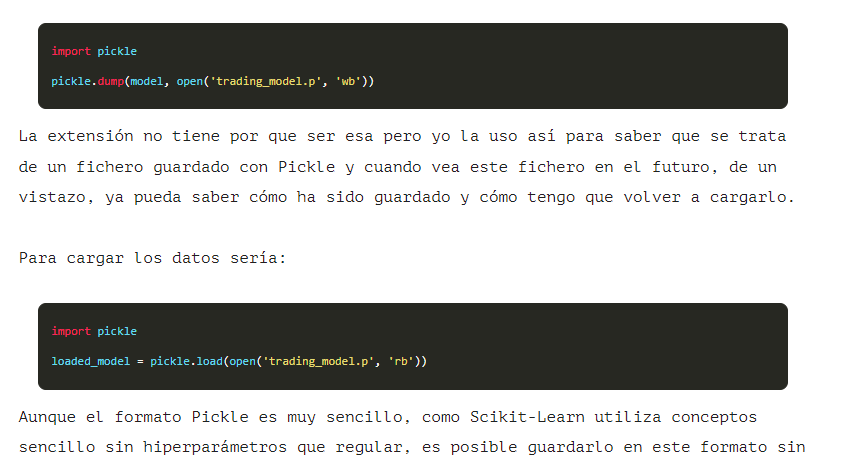

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preparación data

## Load Data

In [ ]:
!unzip "/content/drive/MyDrive/Cursos/Primavera 2022/Inteligencia/Proyecto/Data/Localización de husos sigma.zip" -d "/content/data"
clear_output() 
print('****Base de datos descomprimida****')

****Base de datos descomprimida****


In [ ]:
test_marks    = np.load('test_marks.npy')
test_signals  = np.load('test_signals.npy')
train_marks   = np.load('train_marks.npy')
train_signals = np.load('train_signals.npy')
val_marks     = np.load('val_marks.npy')
val_signals   = np.load('val_signals.npy')

In [ ]:
#Cantidad de datos:
print('Datos de test:', len(test_marks))
print('Datos de entrenamiento:', len(train_marks))
print('Datos de validación:', len(val_marks))
print('Total:', len(test_marks)+len(train_marks)+len(val_marks))

Datos de test: 2256
Datos de entrenamiento: 4463
Datos de validación: 1808
Total: 8527


## Normalización

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(train_signals)

val_signals_normalized = scaler.transform(val_signals)
test_signals_normalized = scaler.transform(test_signals)
train_signals_normalized = scaler.transform(train_signals)

In [ ]:
val_marks = torch.tensor(val_marks)
test_marks = torch.tensor(test_marks)
train_marks = torch.tensor(train_marks)

val_signals = torch.tensor(val_signals_normalized)
test_signals = torch.tensor(test_signals_normalized)
train_signals = torch.tensor(train_signals_normalized)

## Creating Dataset

In [ ]:
train_ds = torch.utils.data.TensorDataset(train_signals, train_marks)
val_ds = torch.utils.data.TensorDataset(val_signals, val_marks)
test_ds = torch.utils.data.TensorDataset(test_signals, test_marks)

## Writing Tensorboard

In [ ]:
writer= SummaryWriter("runs/spindles")

# Entrenamiento y visualización

## Curves

In [ ]:
def show_curves(curves,metric,gpu=False):


    fig, ax = plt.subplots(1, 3, figsize=(16, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1
    if not gpu:
      ax[0].plot(epochs, curves['val_loss'], label='validation')
      ax[0].plot(epochs, curves['train_loss'], label='training')
      ax[0].set_xlabel('Epoch')
      ax[0].set_ylabel('Loss')
      ax[0].set_title('Loss evolution during training')
      ax[0].legend()

      ax[1].plot(epochs, curves['val_acc'], label='validation')
      ax[1].plot(epochs, curves['train_acc'], label='training')
      ax[1].set_xlabel('Epoch')
      ax[1].set_ylabel('Accuracy')
      ax[1].set_title('Accuracy evolution during training')
      ax[1].legend()

      ax[2].plot(epochs, curves['val_metric'], label='validation')
      ax[2].plot(epochs, curves['train_metric'], label='training')
      ax[2].set_xlabel('Epoch')
      ax[2].set_ylabel(f'{metric} promedio')
      ax[2].set_title(f'{metric} evolution during training')
      ax[2].legend()

      plt.show()
    else:
      ax[0].plot(epochs, [x.cpu() for x in curves['val_loss']], label='validation')
      ax[0].plot(epochs, curves['train_loss'], label='training')
      ax[0].set_xlabel('Epoch')
      ax[0].set_ylabel('Loss')
      ax[0].set_title('Loss evolution during training')
      ax[0].legend()

      ax[1].plot(epochs, curves['val_acc'], label='validation')
      ax[1].plot(epochs,  curves['train_acc'], label='training')
      ax[1].set_xlabel('Epoch')
      ax[1].set_ylabel('Accuracy')
      ax[1].set_title('Accuracy evolution during training')
      ax[1].legend()

      ax[2].plot(epochs, curves['val_metric'], label='validation')
      ax[2].plot(epochs, curves['train_metric'], label='training')
      ax[2].set_xlabel('Epoch')
      ax[2].set_ylabel(f'{metric} promedio')
      ax[2].set_title(f'{metric} evolution during training')
      ax[2].legend()

      plt.show()


## IOU

In [ ]:
SMOOTH = 1e-6

def iou_pytorch(y_predicted: torch.Tensor, y_vals: torch.Tensor):

    largo=len(y_vals)
    error_array=np.zeros(largo)
    count=0
    for pred,y_val in zip(y_predicted,y_vals):
        pred=pred.squeeze(0)
        intervalo_inter = [max(pred[0],y_val[0]),min(pred[1],y_val[1])]
        rest = intervalo_inter[1] - intervalo_inter[0]
        inter = rest if rest>0 else 0

        len_predicted = pred[1] - pred[0]
        len_val = y_val[1] - y_val[0]
        union = len_predicted + len_val - inter
        error_array[count]=(inter/(union+1e-6))
        count+=1
        
    return torch.tensor(error_array)

## Dice Score

In [ ]:
SMOOTH = 1e-6

def dice_score(y_predicted: torch.Tensor, y_vals: torch.Tensor):

    largo=len(y_vals)
    error_array=np.zeros(largo)
    count=0
    for pred,y_val in zip(y_predicted,y_vals):
        pred=pred.squeeze(0)
        intervalo_inter = [max(pred[0],y_val[0]),min(pred[1],y_val[1])]
        rest = intervalo_inter[1] - intervalo_inter[0]
        num = 2*rest if rest>0 else 0

        len_predicted = torch.abs(pred[1] - pred[0])  #si tengo error revisar el torch.abs
        len_val = y_val[1] - y_val[0]
        den = len_predicted + len_val
        error_array[count]=(num/(den+1e-6))
        count+=1
        
    return torch.tensor(error_array)

## Evaluation

In [ ]:
def evaluate(val_loader, model, criterion, fun, use_gpu,delta):
    cumulative_loss = 0
    cumulative_predictions = 0
    cumulative_metric = 0
    data_count = 0

    for x_val, y_val in val_loader:
        for x,y in zip(x_val,y_val):   
            x=x.unsqueeze(0)
            x=x.unsqueeze(0)
            if use_gpu:
                x = x.cuda()
                y = y.cuda()
            y_pred=model(x)
            y_pred=y_pred.reshape(2)

            err = criterion(y_pred.unsqueeze(0),y.unsqueeze(0)) ###,eva=True)   

            metric_val = fun(y_pred.unsqueeze(0), y.unsqueeze(0))
            cumulative_predictions += int(metric_val > delta)
            cumulative_loss += err
            cumulative_metric += metric_val
        data_count = x_val.shape[0]

    val_acc = cumulative_predictions / data_count  #data_count = len(y_val)
    val_metric = cumulative_metric / data_count
    val_loss = cumulative_loss/len(y_val)
    return val_acc, val_loss, val_metric

## Training set up

### Train step 

In [ ]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu,delta):

    y_predicted = model(x_batch.unsqueeze(1))     ### DIM (batch_size, channels, data_len)
    
    loss = criterion(y_predicted.squeeze(), y_batch.float())   ### y_predicted e y_batch DEBEN TENER IGUAL DIM

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss

### Train Model

In [ ]:
def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    metric='IoU',
    n_evaluations_per_epoch=6,
    use_gpu=False,
    data_augmentation=False,
    delta=0.7
):

    assert metric in ['IoU', 'Dice Score'], f"Ingresar métrica válida. Métricas esperadas: ['IoU', 'Dice Score'], métrica obtenida: {metric}"

    if use_gpu:
        model.cuda()

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
        "train_metric": [],
        "val_metric": []
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        cumulative_train_metric = 0
        train_loss_count = 0
        train_acc_count = 0

        running_loss=0.0
        running_correct=0
        running_metric = 0

        # Entrenamiento del modelo
        model.train()

        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu, delta)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            # Calculamos número de aciertos
            
            if metric == 'IoU':
                fun = iou_pytorch
            if metric == 'Dice Score':
                fun = dice_score

            metric_val = fun(y_predicted, y_batch)
            
            VP = sum(metric_val > delta).item()
            cumulative_train_corrects += VP
            cumulative_train_metric += torch.sum(metric_val).item()

            running_loss+=loss.item()
            running_correct+=VP
            running_metric+=torch.sum(metric_val).item()

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count
                train_metric = cumulative_train_metric / train_acc_count

                writer.add_scalar('training loss', running_loss / train_loss_count,epoch * n_batches + i)
                writer.add_scalar('training accuracy', running_correct / train_acc_count,epoch * n_batches + i)
                writer.add_scalar('training metric', running_metric / train_acc_count,epoch * n_batches + i)
                running_loss=0.0
                running_correct=0
                running_metric = 0

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}, {metric}: {train_metric}")

            iteration += 1


        model.eval()
        with torch.no_grad():
            val_acc, val_loss, val_metric = evaluate(val_loader, model, criterion, fun, use_gpu, delta)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}, Val {metric}: {val_metric.item()}")

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count
        train_metric = cumulative_train_metric / train_acc_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)
        curves["train_metric"].append(train_metric)
        curves["val_metric"].append(val_metric.item())

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()

    # if data_augmentation:
    #     train_dataset.dataset.transform = original_transform

    return curves

# Models Definition

## Conv1dModel: n° bloques

### 3 bloques

In [ ]:
class CNN1d_Model_three(nn.Module):
    def __init__(
        self,
    ):
        
        super().__init__()
        self.feature_extraction = nn.Sequential(

            nn.Conv1d(1, 8, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(8, 16,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(16,32,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

        )

        self.localization = nn.Sequential(
            
          #nn.Flatten(),
          nn.Conv1d(32,2,kernel_size=100, stride = 1)

        )

    def forward(self, x):
        #print('input: ', x.shape)
        x = self.feature_extraction(x)
        #print('features: ', x.shape)
        x = self.localization(x)
        #x = Postprocesamiento(x)    #quizas hacer postprocesamiento despues de aplicar el modelo
        #print('output:', x.shape)
        return x

### 5 bloques

In [ ]:
class CNN1d_Model_five(nn.Module):
    def __init__(
        self
    ):
        
        super().__init__()
        self.feature_extraction = nn.Sequential(

            nn.Conv1d(1, 8, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(8, 16,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(16,32,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32,64,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64,128,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2)

        )

        self.localization = nn.Conv1d(128,2,kernel_size=25, stride = 1)

    def forward(self, x):
        x = self.feature_extraction(x)
        x = self.localization(x)
        return x

### 7 bloques

In [ ]:
class CNN1d_Model_seven(nn.Module):
    def __init__(
        self
    ):
        
        super().__init__()
        self.feature_extraction = nn.Sequential(

            nn.Conv1d(1, 8, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(8, 16,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(16,32,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32,64,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64,128,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128,256,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(256,512,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2)

        )

        self.localization = nn.Conv1d(512,2,kernel_size=6, stride = 1)

    def forward(self, x):
        x = self.feature_extraction(x)
        x = self.localization(x)
        return x

### 9 bloques

In [ ]:
class CNN1d_Model_nine(nn.Module):
    def __init__(
        self
    ):
        
        super().__init__()
        self.feature_extraction = nn.Sequential(

            nn.Conv1d(1, 8, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(8, 16,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(16,32,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32,64,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64,128,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128,256,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(256,512,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(512,1024,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(1024,2048,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

        )

        self.localization = nn.Conv1d(2048,2,kernel_size=1, stride = 1)

    def forward(self, x):
        x = self.feature_extraction(x)
        x = self.localization(x)
        return x

## Tamaño del kernel

In [ ]:
class CNN1d_Model_kernel(nn.Module):
    def __init__(
        self,
        kernel
    ):
        
        super().__init__()
        self.feature_extraction = nn.Sequential(

            nn.Conv1d(1, 8, kernel_size=kernel, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(8, 16,kernel_size=kernel, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(16,32,kernel_size=kernel, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32,64,kernel_size=kernel, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64,128,kernel_size=kernel, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128,256,kernel_size=kernel, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(256,512,kernel_size=kernel, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(512,1024,kernel_size=kernel, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(1024,2048,kernel_size=kernel, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

        )

        self.localization = nn.Conv1d(2048,2,kernel_size=1, stride = 1)

    def forward(self, x):
        x = self.feature_extraction(x)
        x = self.localization(x)
        return x

## Batch normalization

### 1 capa con batch normalization

In [ ]:
class CNN1d_Model_ninebatch1(nn.Module):
    def __init__(
        self
    ):
        
        super().__init__()
        self.feature_extraction = nn.Sequential(

            nn.Conv1d(1, 8, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(8),

            nn.Conv1d(8, 16,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(16,32,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32,64,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64,128,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128,256,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(256,512,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(512,1024,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(1024,2048,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

        )

        self.localization = nn.Conv1d(2048,2,kernel_size=1, stride = 1)

    def forward(self, x):
        x = self.feature_extraction(x)
        x = self.localization(x)
        return x

### 3 capas con batch normalization

In [ ]:
class CNN1d_Model_ninebatch3(nn.Module):
    def __init__(
        self
    ):
        
        super().__init__()
        self.feature_extraction = nn.Sequential(

            nn.Conv1d(1, 8, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(8),

            nn.Conv1d(8, 16,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(16),

            nn.Conv1d(16,32,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(32),

            nn.Conv1d(32,64,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64,128,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128,256,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(256,512,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(512,1024,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(1024,2048,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

        )

        self.localization = nn.Conv1d(2048,2,kernel_size=1, stride = 1)

    def forward(self, x):
        x = self.feature_extraction(x)
        x = self.localization(x)
        return x

### 6 capas con batch normalization

In [ ]:
class CNN1d_Model_ninebatch6(nn.Module):
    def __init__(
        self
    ):
        
        super().__init__()
        self.feature_extraction = nn.Sequential(

            nn.Conv1d(1, 8, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(8),

            nn.Conv1d(8, 16,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(16),

            nn.Conv1d(16,32,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(32),

            nn.Conv1d(32,64,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(64),

            nn.Conv1d(64,128,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(128),

            nn.Conv1d(128,256,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(256),

            nn.Conv1d(256,512,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(512,1024,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(1024,2048,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

        )

        self.localization = nn.Conv1d(2048,2,kernel_size=1, stride = 1)

    def forward(self, x):
        x = self.feature_extraction(x)
        x = self.localization(x)
        return x

### 9 capas con batch normalization

In [ ]:
class CNN1d_Model_ninebatch9(nn.Module):
    def __init__(
        self
    ):
        
        super().__init__()
        self.feature_extraction = nn.Sequential(

            nn.Conv1d(1, 8, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(8),

            nn.Conv1d(8, 16,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(16),

            nn.Conv1d(16,32,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(32),

            nn.Conv1d(32,64,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(64),

            nn.Conv1d(64,128,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(128),

            nn.Conv1d(128,256,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(256),

            nn.Conv1d(256,512,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(512),

            nn.Conv1d(512,1024,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(1024),

            nn.Conv1d(1024,2048,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(2048),

        )

        self.localization = nn.Conv1d(2048,2,kernel_size=1, stride = 1)

    def forward(self, x):
        x = self.feature_extraction(x)
        x = self.localization(x)
        return x

# Training: busqueda mejor modelo

In [ ]:
lr = 0.005  #probar mas bajo
batch_size = 64

criterion = torch.nn.MSELoss()
epochs = 40
metric = 'IoU'

## n° bloques convolucionales

### Tres bloques

In [ ]:
run_n_times = 5
curves_three = []

for run in range(run_n_times):
    print(f"Entrenando corrida número {run + 1}/{run_n_times}")
    CNN1d = CNN1d_Model_three()
    curves = train_model(
        CNN1d,
        train_ds,
        val_ds,
        epochs,
        criterion,
        batch_size,
        lr,
        metric='IoU',
        use_gpu=True,
        data_augmentation=False,
        delta=0.7
    )
    curves_three.append(curves)
    show_curves(curves, metric, gpu=True)

Entrenando corrida número 1/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 161563.40104166666, Train acc: 0.0, IoU: 0.0
Iteration 22 - Batch 22/70 - Train loss: 105490.38824728261, Train acc: 0.004076086956521739, IoU: 0.03471348821160617
Iteration 33 - Batch 33/70 - Train loss: 77369.26229319852, Train acc: 0.04136029411764706, IoU: 0.124825673899188
Iteration 44 - Batch 44/70 - Train loss: 62112.37584635417, Train acc: 0.058680555555555555, IoU: 0.1871837559815453
Iteration 55 - Batch 55/70 - Train loss: 52418.58796037947, Train acc: 0.07505580357142858, IoU: 0.21673432759787456
Iteration 66 - Batch 66/70 - Train loss: 45836.452410797574, Train acc: 0.08395522388059702, IoU: 0.23803487365316767
Val loss: 11991.001953125, Val acc: 0.14325221238938052, Val IoU: 0.37444939782072706
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 12311.266031901041, Train acc: 0.1328125, IoU: 0.358743193866682
Iteration 92 - Batch 22/70 - Train loss: 11377.720703125, Train acc: 0.1460597826086

KeyboardInterrupt: ignored

### Cinco bloques

Entrenando corrida número 1/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 114653.31494140625, Train acc: 0.0, IoU: 0.03146787376378294
Iteration 22 - Batch 22/70 - Train loss: 74415.69284986414, Train acc: 0.03940217391304348, IoU: 0.1501811847306469
Iteration 33 - Batch 33/70 - Train loss: 55894.642606847425, Train acc: 0.059283088235294115, IoU: 0.20366883067291544
Iteration 44 - Batch 44/70 - Train loss: 45494.76456163194, Train acc: 0.07777777777777778, IoU: 0.23715105573448655
Iteration 55 - Batch 55/70 - Train loss: 38921.93495396205, Train acc: 0.08928571428571429, IoU: 0.2615975161423713
Iteration 66 - Batch 66/70 - Train loss: 34359.60067339086, Train acc: 0.1009794776119403, IoU: 0.2780702520704469
Val loss: 9686.6005859375, Val acc: 0.15376106194690264, Val IoU: 0.3854037561532176
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 10554.276774088541, Train acc: 0.15104166666666666, IoU: 0.37910072312729426
Iteration 92 - Batch 22/70 - Train loss: 10551.362856657608,

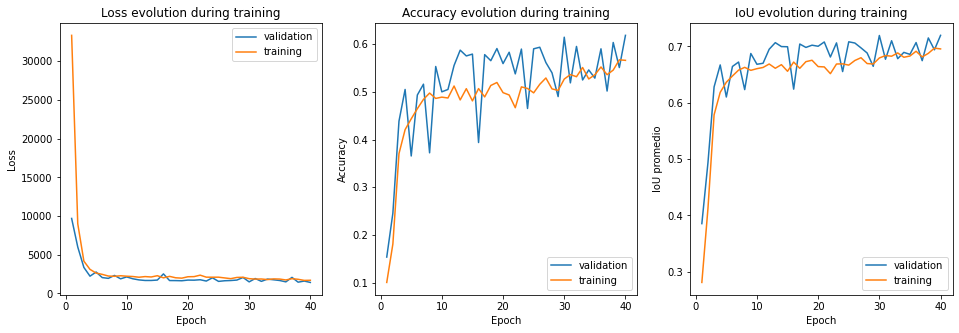

Entrenando corrida número 2/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 111213.37923177083, Train acc: 0.0026041666666666665, IoU: 0.034684907912681716
Iteration 22 - Batch 22/70 - Train loss: 71646.42459239131, Train acc: 0.041440217391304345, IoU: 0.16192683402487487
Iteration 33 - Batch 33/70 - Train loss: 53890.822639016544, Train acc: 0.05238970588235294, IoU: 0.20723189364083042
Iteration 44 - Batch 44/70 - Train loss: 44148.728016493056, Train acc: 0.06736111111111111, IoU: 0.23780481820561666
Iteration 55 - Batch 55/70 - Train loss: 37761.356166294645, Train acc: 0.08705357142857142, IoU: 0.2676800442661147
Iteration 66 - Batch 66/70 - Train loss: 33326.59583430504, Train acc: 0.09934701492537314, IoU: 0.2843063925555549
Val loss: 9198.048828125, Val acc: 0.168141592920354, Val IoU: 0.40374847832891136
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 10341.912801106771, Train acc: 0.17578125, IoU: 0.39152005668817463
Iteration 92 - Batch 22/70 - Train loss: 9880.60

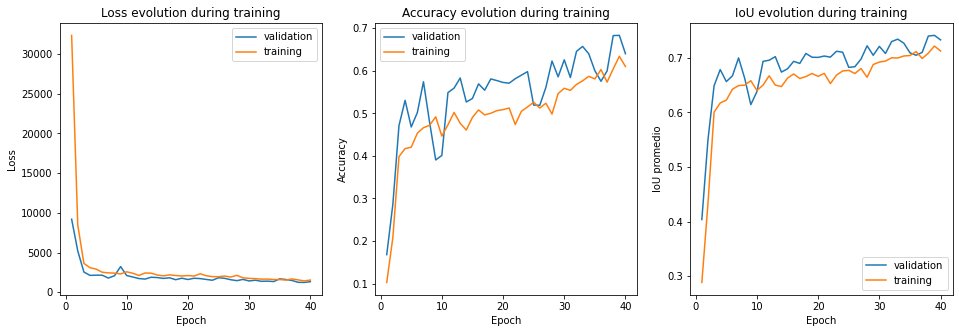

Entrenando corrida número 3/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 110961.18994140625, Train acc: 0.0013020833333333333, IoU: 0.04376003557263175
Iteration 22 - Batch 22/70 - Train loss: 76702.17875339674, Train acc: 0.03260869565217391, IoU: 0.13677597740942196
Iteration 33 - Batch 33/70 - Train loss: 58342.674144071694, Train acc: 0.04871323529411765, IoU: 0.18346757727672144
Iteration 44 - Batch 44/70 - Train loss: 47946.409592013886, Train acc: 0.058680555555555555, IoU: 0.2137903173985453
Iteration 55 - Batch 55/70 - Train loss: 41143.97017996652, Train acc: 0.07672991071428571, IoU: 0.24592588805686383
Iteration 66 - Batch 66/70 - Train loss: 36307.30124766791, Train acc: 0.08861940298507463, IoU: 0.26496880865445055
Val loss: 11593.224609375, Val acc: 0.14325221238938052, Val IoU: 0.36480349896584685
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 11757.3623046875, Train acc: 0.14453125, IoU: 0.3686782089321241
Iteration 92 - Batch 22/70 - Train loss: 11314.76

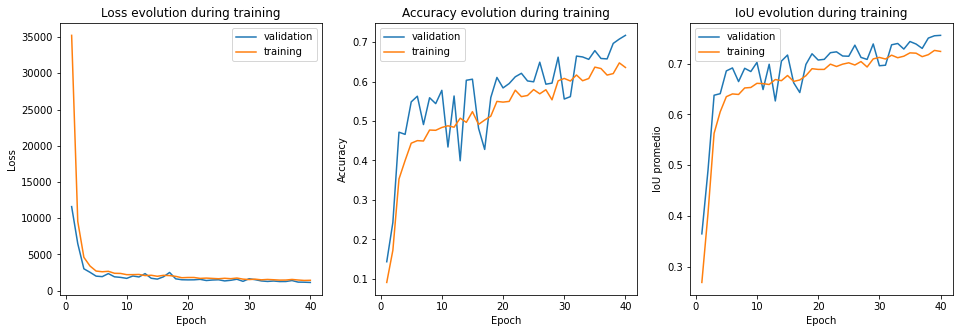

Entrenando corrida número 4/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 121535.26888020833, Train acc: 0.00390625, IoU: 0.02230994227905588
Iteration 22 - Batch 22/70 - Train loss: 78319.20278532608, Train acc: 0.03736413043478261, IoU: 0.14139784022613047
Iteration 33 - Batch 33/70 - Train loss: 58754.578239889706, Train acc: 0.05284926470588235, IoU: 0.1968907754535929
Iteration 44 - Batch 44/70 - Train loss: 47621.053385416664, Train acc: 0.06736111111111111, IoU: 0.22907331253895286
Iteration 55 - Batch 55/70 - Train loss: 40593.25833565848, Train acc: 0.08147321428571429, IoU: 0.2575714795448424
Iteration 66 - Batch 66/70 - Train loss: 35711.469070662315, Train acc: 0.09281716417910447, IoU: 0.27478981051694973
Val loss: 9879.5029296875, Val acc: 0.1532079646017699, Val IoU: 0.38274036533524514
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 10779.512776692709, Train acc: 0.15755208333333334, IoU: 0.3756417039934756
Iteration 92 - Batch 22/70 - Train loss: 10619.9331

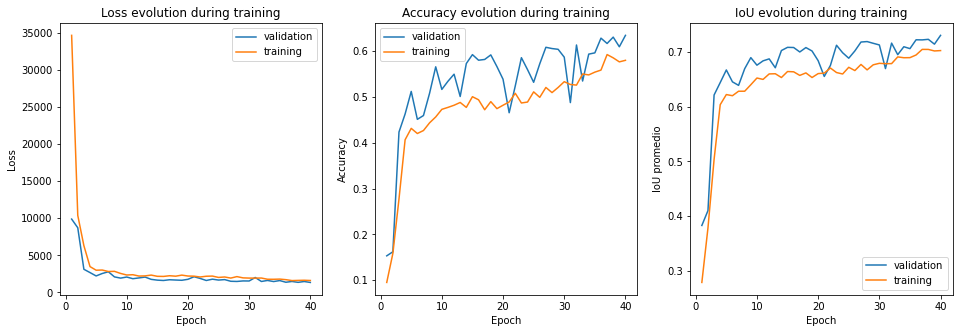

Entrenando corrida número 5/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 117775.70052083333, Train acc: 0.0013020833333333333, IoU: 0.01618362840129824
Iteration 22 - Batch 22/70 - Train loss: 75820.83661684782, Train acc: 0.021739130434782608, IoU: 0.1257768021266162
Iteration 33 - Batch 33/70 - Train loss: 57153.185029871325, Train acc: 0.051011029411764705, IoU: 0.19090190659757997
Iteration 44 - Batch 44/70 - Train loss: 46462.2923828125, Train acc: 0.05451388888888889, IoU: 0.21659715804084953
Iteration 55 - Batch 55/70 - Train loss: 39534.959001813615, Train acc: 0.07672991071428571, IoU: 0.2511845307553123
Iteration 66 - Batch 66/70 - Train loss: 34826.61890741604, Train acc: 0.09071828358208955, IoU: 0.26845238144939226
Val loss: 10135.0146484375, Val acc: 0.14657079646017698, Val IoU: 0.3745284915769208
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 11239.566731770834, Train acc: 0.15234375, IoU: 0.35670835714593824
Iteration 92 - Batch 22/70 - Train loss: 11016.

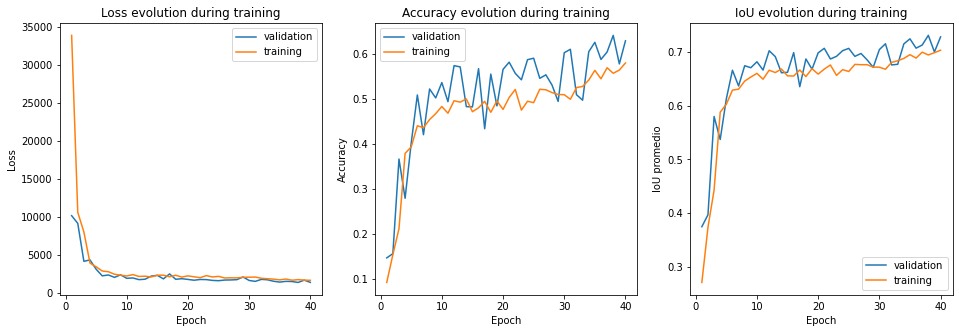

In [ ]:
run_n_times = 5
curves_five = []

for run in range(run_n_times):
    print(f"Entrenando corrida número {run + 1}/{run_n_times}")
    CNN1d = CNN1d_Model_five()
    curves = train_model(
        CNN1d,
        train_ds,
        val_ds,
        epochs,
        criterion,
        batch_size,
        lr,
        metric='IoU',
        use_gpu=True,
        data_augmentation=False,
        delta=0.7
    )
    curves_five.append(curves)
    show_curves(curves, metric, gpu=True)

### Siete bloques

Entrenando corrida número 1/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 85311.236328125, Train acc: 0.029947916666666668, IoU: 0.11547390243716411
Iteration 22 - Batch 22/70 - Train loss: 52901.98089334239, Train acc: 0.05366847826086957, IoU: 0.21099342030198465
Iteration 33 - Batch 33/70 - Train loss: 39676.2241785386, Train acc: 0.0739889705882353, IoU: 0.2522259507365347
Iteration 44 - Batch 44/70 - Train loss: 32924.94351128472, Train acc: 0.0920138888888889, IoU: 0.2775288911813024
Iteration 55 - Batch 55/70 - Train loss: 28721.518310546875, Train acc: 0.10239955357142858, IoU: 0.296442073430902
Iteration 66 - Batch 66/70 - Train loss: 25760.189219916047, Train acc: 0.109375, IoU: 0.3079794692520368
Val loss: 10087.4189453125, Val acc: 0.15597345132743362, Val IoU: 0.39238667982615366
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 10744.598714192709, Train acc: 0.17838541666666666, IoU: 0.37943165611280466
Iteration 92 - Batch 22/70 - Train loss: 11187.56644870924,

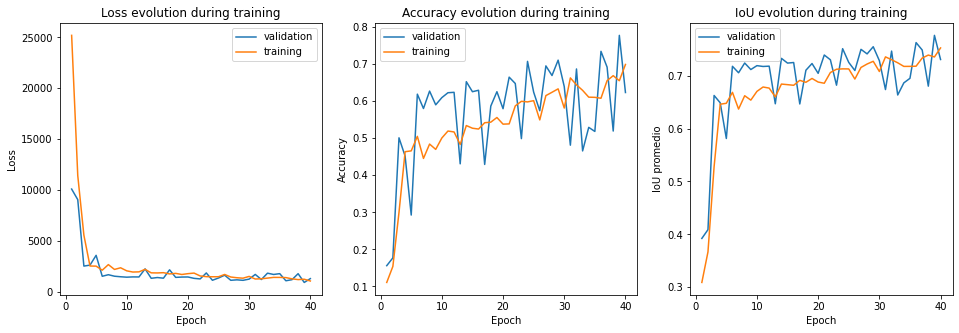

Entrenando corrida número 2/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 78963.77498372395, Train acc: 0.03125, IoU: 0.15188667543255482
Iteration 22 - Batch 22/70 - Train loss: 47908.55086616848, Train acc: 0.06589673913043478, IoU: 0.23644766610501075
Iteration 33 - Batch 33/70 - Train loss: 36202.552217371325, Train acc: 0.08042279411764706, IoU: 0.27464109985617946
Iteration 44 - Batch 44/70 - Train loss: 29954.52847222222, Train acc: 0.09583333333333334, IoU: 0.2965487015862083
Iteration 55 - Batch 55/70 - Train loss: 25991.228062220984, Train acc: 0.10909598214285714, IoU: 0.315746963185055
Iteration 66 - Batch 66/70 - Train loss: 23140.687281366605, Train acc: 0.12639925373134328, IoU: 0.33420767108949423
Val loss: 6956.46142578125, Val acc: 0.2461283185840708, Val IoU: 0.4800001054935763
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 5932.918212890625, Train acc: 0.22916666666666666, IoU: 0.4888087169327567
Iteration 92 - Batch 22/70 - Train loss: 5086.20370881453

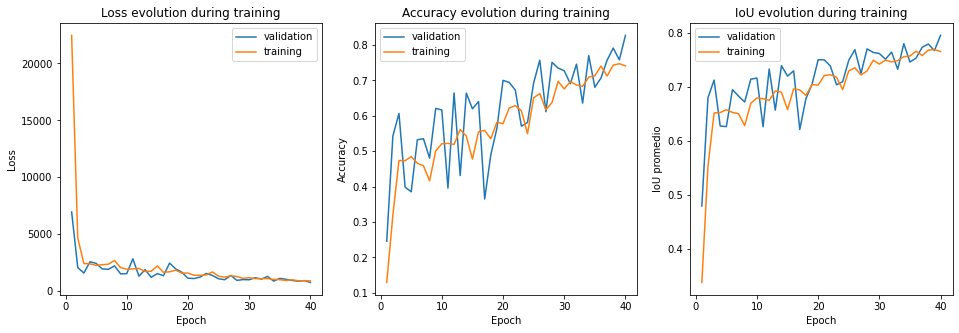

Entrenando corrida número 3/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 138307.54850260416, Train acc: 0.0, IoU: 0.025991063663013847
Iteration 22 - Batch 22/70 - Train loss: 145792.48114809784, Train acc: 0.0, IoU: 0.01356055495461592
Iteration 33 - Batch 33/70 - Train loss: 128478.52567784926, Train acc: 0.008731617647058824, IoU: 0.03298333083086939
Iteration 44 - Batch 44/70 - Train loss: 102924.66840277778, Train acc: 0.03993055555555555, IoU: 0.09854347911904268
Iteration 55 - Batch 55/70 - Train loss: 85739.36811174665, Train acc: 0.058872767857142856, IoU: 0.14674505842717572
Iteration 66 - Batch 66/70 - Train loss: 73797.42664120802, Train acc: 0.07206156716417911, IoU: 0.17928342076596376
Val loss: 10839.9912109375, Val acc: 0.15099557522123894, Val IoU: 0.37515971285965943
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 12579.953043619791, Train acc: 0.13932291666666666, IoU: 0.3372606330529682
Iteration 92 - Batch 22/70 - Train loss: 12208.22707201087, Train a

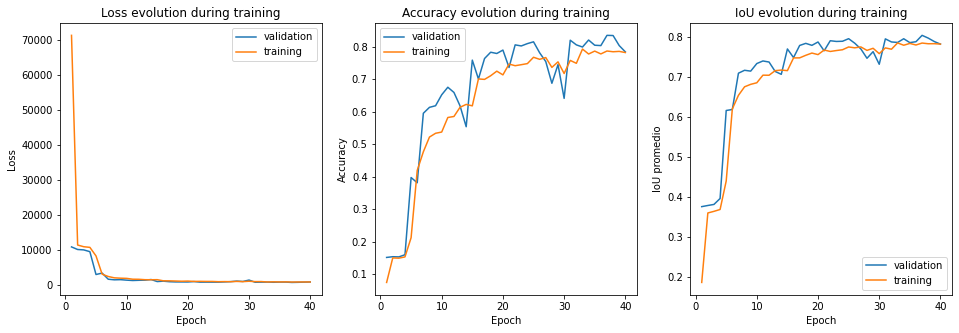

Entrenando corrida número 4/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 126531.25423177083, Train acc: 0.0026041666666666665, IoU: 0.03582499829644803
Iteration 22 - Batch 22/70 - Train loss: 130212.32625679347, Train acc: 0.001358695652173913, IoU: 0.018727261160561087
Iteration 33 - Batch 33/70 - Train loss: 101128.6209788603, Train acc: 0.021139705882352942, IoU: 0.09310320154819397
Iteration 44 - Batch 44/70 - Train loss: 82123.75407986112, Train acc: 0.024652777777777777, IoU: 0.12387100042235236
Iteration 55 - Batch 55/70 - Train loss: 68604.53323800223, Train acc: 0.041294642857142856, IoU: 0.16553956775788134
Iteration 66 - Batch 66/70 - Train loss: 59341.66502448694, Train acc: 0.05643656716417911, IoU: 0.19801811287621304
Val loss: 10577.5, Val acc: 0.14491150442477876, Val IoU: 0.3617045314789624
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 11281.750569661459, Train acc: 0.15104166666666666, IoU: 0.35640237930973245
Iteration 92 - Batch 22/70 - Train loss: 1

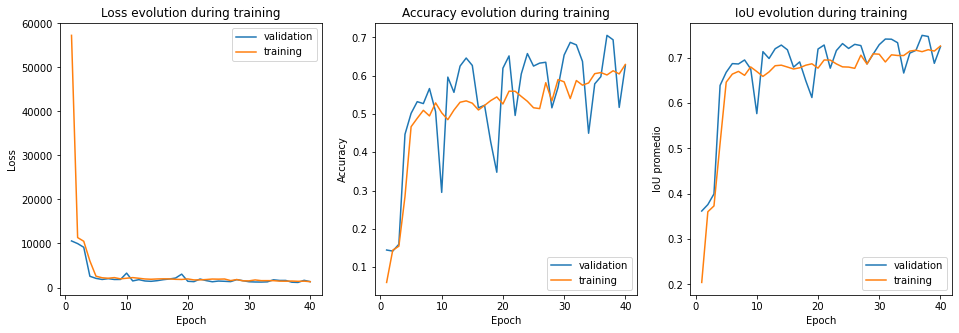

Entrenando corrida número 5/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 134969.11686197916, Train acc: 0.0, IoU: 0.009706612243462587
Iteration 22 - Batch 22/70 - Train loss: 127237.11056385869, Train acc: 0.0, IoU: 0.01018727240111532
Iteration 33 - Batch 33/70 - Train loss: 96034.33840762867, Train acc: 0.021599264705882353, IoU: 0.0999903460722314
Iteration 44 - Batch 44/70 - Train loss: 76760.25798611112, Train acc: 0.028819444444444446, IoU: 0.1415005321987135
Iteration 55 - Batch 55/70 - Train loss: 64291.05916922433, Train acc: 0.04575892857142857, IoU: 0.18275082669270862
Iteration 66 - Batch 66/70 - Train loss: 55592.562325093284, Train acc: 0.0625, IoU: 0.21269921441177966
Val loss: 10310.880859375, Val acc: 0.13495575221238937, Val IoU: 0.35841094258906364
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 11096.074055989584, Train acc: 0.15885416666666666, IoU: 0.3633157123041049
Iteration 92 - Batch 22/70 - Train loss: 10999.461149796196, Train acc: 0.1487771739

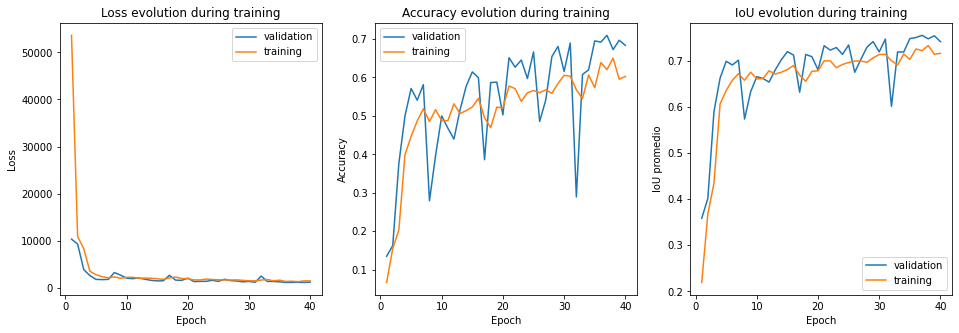

In [ ]:
run_n_times = 5
curves_seven = []

for run in range(run_n_times):
    print(f"Entrenando corrida número {run + 1}/{run_n_times}")
    CNN1d = CNN1d_Model_seven()
    curves = train_model(
        CNN1d,
        train_ds,
        val_ds,
        epochs,
        criterion,
        batch_size,
        lr,
        metric='IoU',
        use_gpu=True,
        data_augmentation=False,
        delta=0.7
    )
    curves_seven.append(curves)
    show_curves(curves, metric, gpu=True)

### Nueve bloques

Entrenando corrida número 1/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 170441.75341796875, Train acc: 0.01171875, IoU: 0.043482702817224585
Iteration 22 - Batch 22/70 - Train loss: 174891.26197350543, Train acc: 0.006114130434782609, IoU: 0.02268662755681283
Iteration 33 - Batch 33/70 - Train loss: 157629.69244025735, Train acc: 0.007352941176470588, IoU: 0.03225434177267563
Iteration 44 - Batch 44/70 - Train loss: 127342.65240885416, Train acc: 0.025694444444444443, IoU: 0.08127332897995908
Iteration 55 - Batch 55/70 - Train loss: 106149.40267508371, Train acc: 0.036830357142857144, IoU: 0.12026924349920774
Iteration 66 - Batch 66/70 - Train loss: 90813.99823635728, Train acc: 0.05433768656716418, IoU: 0.15669325397942657
Val loss: 10537.6123046875, Val acc: 0.1543141592920354, Val IoU: 0.38318414179703136
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 11084.601155598959, Train acc: 0.15364583333333334, IoU: 0.368311425444972
Iteration 92 - Batch 22/70 - Train loss: 11

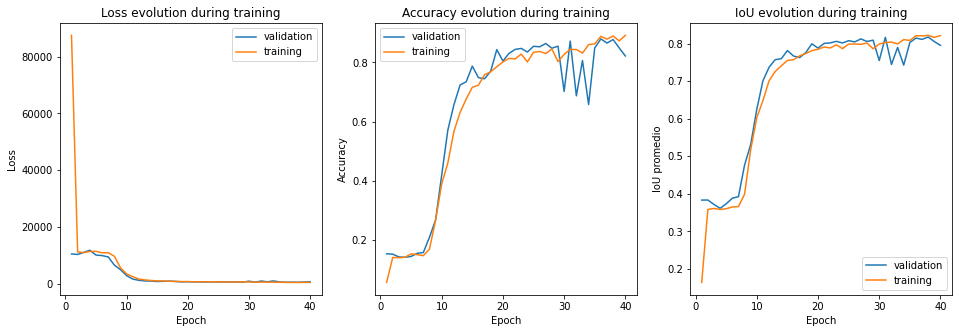

Entrenando corrida número 2/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 868659.1333007812, Train acc: 0.01171875, IoU: 0.05466431423701579
Iteration 22 - Batch 22/70 - Train loss: 539740.861667799, Train acc: 0.006114130434782609, IoU: 0.028520511775834322
Iteration 33 - Batch 33/70 - Train loss: 393440.4833984375, Train acc: 0.006893382352941176, IoU: 0.04276436507729266
Iteration 44 - Batch 44/70 - Train loss: 300682.9342013889, Train acc: 0.03298611111111111, IoU: 0.12446724984845585
Iteration 55 - Batch 55/70 - Train loss: 243799.9989013672, Train acc: 0.05552455357142857, IoU: 0.16633389169918797
Iteration 66 - Batch 66/70 - Train loss: 205679.58077775186, Train acc: 0.06879664179104478, IoU: 0.1970888615416847
Val loss: 12478.19921875, Val acc: 0.15597345132743362, Val IoU: 0.3958790595520561
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 11449.778401692709, Train acc: 0.1484375, IoU: 0.35950509999012564
Iteration 92 - Batch 22/70 - Train loss: 11948.98683763587, T

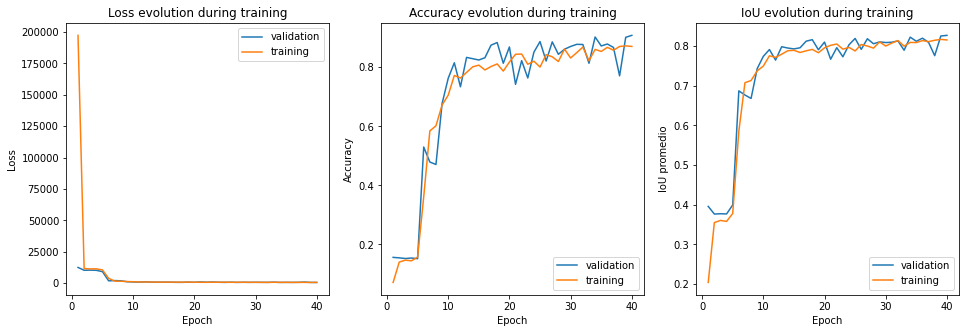

Entrenando corrida número 3/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 1144753.3059895833, Train acc: 0.0078125, IoU: 0.03718708094371929
Iteration 22 - Batch 22/70 - Train loss: 677866.4979619565, Train acc: 0.004076086956521739, IoU: 0.01940195527498398
Iteration 33 - Batch 33/70 - Train loss: 471695.2464384191, Train acc: 0.019761029411764705, IoU: 0.07515518998943929
Iteration 44 - Batch 44/70 - Train loss: 360409.7130208333, Train acc: 0.035069444444444445, IoU: 0.1407703252699927
Iteration 55 - Batch 55/70 - Train loss: 292279.0977783203, Train acc: 0.04603794642857143, IoU: 0.17262664281780157
Iteration 66 - Batch 66/70 - Train loss: 246129.08899836754, Train acc: 0.06319962686567164, IoU: 0.20860610200100776
Val loss: 10547.7607421875, Val acc: 0.12444690265486726, Val IoU: 0.344403081529029
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 10470.196370442709, Train acc: 0.13932291666666666, IoU: 0.36081210651097234
Iteration 92 - Batch 22/70 - Train loss: 10829.02

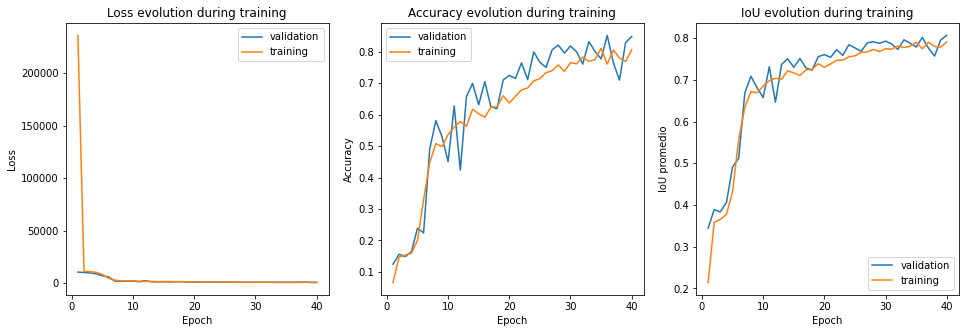

Entrenando corrida número 4/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 509406.4860026042, Train acc: 0.0026041666666666665, IoU: 0.024663267522100796
Iteration 22 - Batch 22/70 - Train loss: 349422.8296535326, Train acc: 0.001358695652173913, IoU: 0.012867791750661285
Iteration 33 - Batch 33/70 - Train loss: 256469.16055836398, Train acc: 0.014705882352941176, IoU: 0.0506369290931295
Iteration 44 - Batch 44/70 - Train loss: 198102.2616970486, Train acc: 0.036458333333333336, IoU: 0.12714152348251243
Iteration 55 - Batch 55/70 - Train loss: 161757.58340890068, Train acc: 0.04827008928571429, IoU: 0.16147310306012383
Iteration 66 - Batch 66/70 - Train loss: 137086.001953125, Train acc: 0.06506529850746269, IoU: 0.19567717182953448
Val loss: 10923.8623046875, Val acc: 0.14823008849557523, Val IoU: 0.36951876576181225
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 11203.04638671875, Train acc: 0.140625, IoU: 0.35262878217431154
Iteration 92 - Batch 22/70 - Train loss: 11479

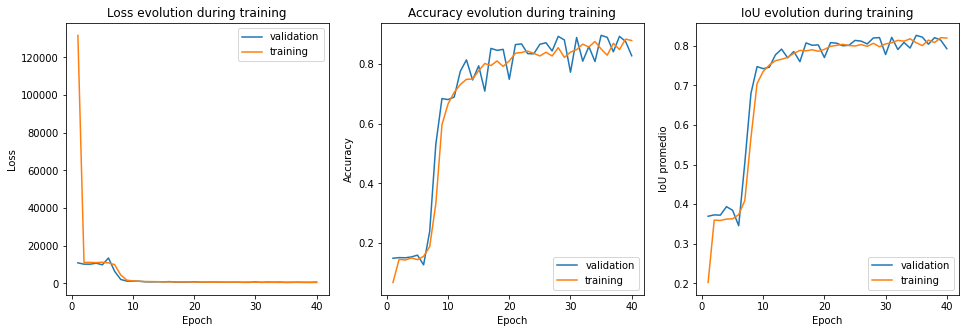

Entrenando corrida número 5/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 1535259.2639973958, Train acc: 0.006510416666666667, IoU: 0.03292925789840714
Iteration 22 - Batch 22/70 - Train loss: 886914.7063519022, Train acc: 0.0033967391304347825, IoU: 0.017180482381777634
Iteration 33 - Batch 33/70 - Train loss: 630262.1868106618, Train acc: 0.002297794117647059, IoU: 0.020694189452436094
Iteration 44 - Batch 44/70 - Train loss: 479732.6912543403, Train acc: 0.027430555555555555, IoU: 0.09465710447517874
Iteration 55 - Batch 55/70 - Train loss: 387852.09375, Train acc: 0.04994419642857143, IoU: 0.15309375935919434
Iteration 66 - Batch 66/70 - Train loss: 326001.5226795709, Train acc: 0.061567164179104475, IoU: 0.18383221071190856
Val loss: 10266.466796875, Val acc: 0.1404867256637168, Val IoU: 0.3696839077436911
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 11829.20263671875, Train acc: 0.1484375, IoU: 0.3468400029898741
Iteration 92 - Batch 22/70 - Train loss: 11397.17382

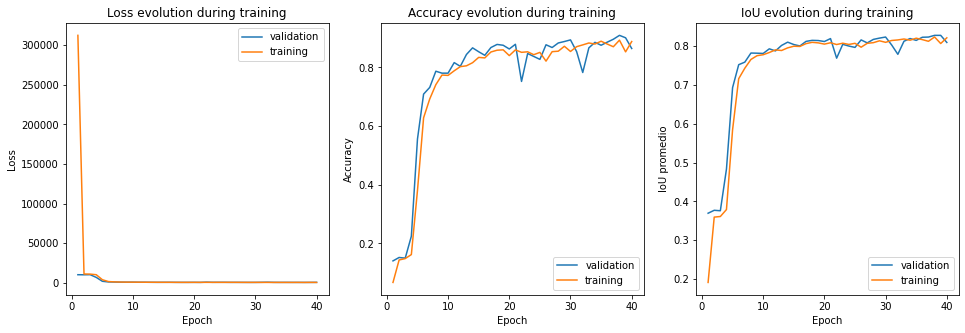

In [ ]:
run_n_times = 5
curves_nine = []

for run in range(run_n_times):
    print(f"Entrenando corrida número {run + 1}/{run_n_times}")
    CNN1d = CNN1d_Model_nine()
    curves = train_model(
        CNN1d,
        train_ds,
        val_ds,
        epochs,
        criterion,
        batch_size,
        lr,
        metric='IoU',
        use_gpu=True,
        data_augmentation=False,
        delta=0.7
    )
    curves_nine.append(curves)
    show_curves(curves, metric, gpu=True)

## Tamaño del kernel

### kernel_size = 2

Epoch 1/30
Iteration 11 - Batch 11/70 - Train loss: 111987.2646484375, Train acc: 0.009114583333333334, IoU: 0.049898121433822475
Iteration 22 - Batch 22/70 - Train loss: 80149.28065557065, Train acc: 0.014266304347826086, IoU: 0.09179408439906736
Iteration 33 - Batch 33/70 - Train loss: 59688.559541590075, Train acc: 0.04549632352941176, IoU: 0.17442287560788827
Iteration 44 - Batch 44/70 - Train loss: 48366.954969618055, Train acc: 0.051041666666666666, IoU: 0.2032078454858947
Iteration 55 - Batch 55/70 - Train loss: 41064.45690917969, Train acc: 0.07087053571428571, IoU: 0.23697596089438985
Iteration 66 - Batch 66/70 - Train loss: 36124.08847364739, Train acc: 0.08092350746268656, IoU: 0.25658926554021844
Val loss: 10102.5576171875, Val acc: 0.15873893805309736, Val IoU: 0.404423899340475
Epoch 2/30
Iteration 81 - Batch 11/70 - Train loss: 10830.534912109375, Train acc: 0.16145833333333334, IoU: 0.3782908088289029
Iteration 92 - Batch 22/70 - Train loss: 11428.548743206522, Train ac

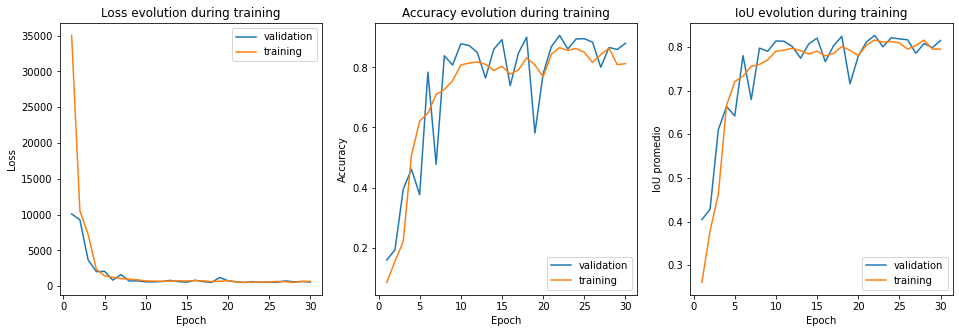

In [ ]:
CNN1d = CNN1d_Model_kernel(kernel=2)
k_size_2_curves = train_model(
    CNN1d,
    train_ds,
    val_ds,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
    data_augmentation=False,
    delta=0.7
)
show_curves(k_size_2_curves, gpu=True)

### kernel_size = 3

In [ ]:
CNN1d = CNN1d_Model_kernel(kernel=3)
k_size_3_curves = train_model(
    CNN1d,
    train_ds,
    val_ds,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
    data_augmentation=False,
    delta=0.7
)
show_curves(k_size_3_curves, gpu=True)

Epoch 1/30
Iteration 11 - Batch 11/70 - Train loss: 638902.4716796875, Train acc: 0.006510416666666667, IoU: 0.03301243621657098
Iteration 22 - Batch 22/70 - Train loss: 412473.1734035326, Train acc: 0.0033967391304347825, IoU: 0.01722387976516747
Iteration 33 - Batch 33/70 - Train loss: 291920.0279756434, Train acc: 0.0059742647058823525, IoU: 0.057907889361866395
Iteration 44 - Batch 44/70 - Train loss: 225208.37769097224, Train acc: 0.025347222222222222, IoU: 0.12713977776639795
Iteration 55 - Batch 55/70 - Train loss: 183899.4452950614, Train acc: 0.04547991071428571, IoU: 0.16639641286805126
Iteration 66 - Batch 66/70 - Train loss: 155637.99173565765, Train acc: 0.05713619402985075, IoU: 0.19196530132102343
Val loss: 10406.8134765625, Val acc: 0.1515486725663717, Val IoU: 0.37034465830605673
Epoch 2/30
Iteration 81 - Batch 11/70 - Train loss: 11696.962809244791, Train acc: 0.14583333333333334, IoU: 0.3486967101242347
Iteration 92 - Batch 22/70 - Train loss: 11426.299634850544, Tra

### kernel_size = 4

Epoch 1/30
Iteration 11 - Batch 11/70 - Train loss: 170308.44921875, Train acc: 0.0, IoU: 0.0030143447414351008
Iteration 22 - Batch 22/70 - Train loss: 152112.8957201087, Train acc: 0.0, IoU: 0.00845822144986849
Iteration 33 - Batch 33/70 - Train loss: 111034.02553423714, Train acc: 0.028952205882352942, IoU: 0.09871799091760135
Iteration 44 - Batch 44/70 - Train loss: 86981.84294704862, Train acc: 0.04548611111111111, IoU: 0.15798089908020202
Iteration 55 - Batch 55/70 - Train loss: 72157.20785086496, Train acc: 0.06166294642857143, IoU: 0.19339578678168273
Iteration 66 - Batch 66/70 - Train loss: 62166.554512593284, Train acc: 0.07649253731343283, IoU: 0.22360568869591807
Val loss: 10808.041015625, Val acc: 0.1261061946902655, Val IoU: 0.3478171702276553
Epoch 2/30
Iteration 81 - Batch 11/70 - Train loss: 10866.08349609375, Train acc: 0.14713541666666666, IoU: 0.36108621928481927
Iteration 92 - Batch 22/70 - Train loss: 10972.219471807066, Train acc: 0.15217391304347827, IoU: 0.3644

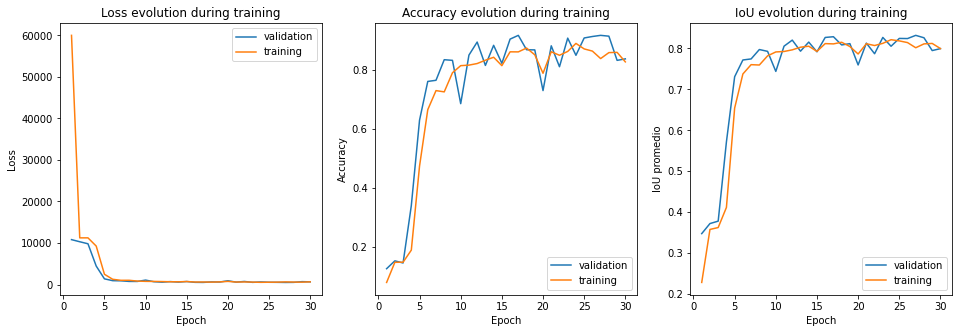

In [ ]:
CNN1d = CNN1d_Model_kernel(kernel=4)
k_size_4_curves = train_model(
    CNN1d,
    train_ds,
    val_ds,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
    data_augmentation=False,
    delta=0.7
)
show_curves(k_size_4_curves, gpu=True)

### kernel_size = 5

In [ ]:
CNN1d = CNN1d_Model_kernel(kernel=5)
k_size_5_curves = train_model(
    CNN1d,
    train_ds,
    val_ds,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
    data_augmentation=False,
    delta=0.7
)
show_curves(k_size_5_curves, gpu=True)

## Batch Normalization

### Batch Normalization 1 capa

In [ ]:
if not Path('curves_batch_one.pickle').is_file():
  run_n_times = 5
  curves_batch_one = []
  modelsbatch1=[]
  for run in range(run_n_times):
      print(f"Entrenando corrida número {run + 1}/{run_n_times}")
      CNN1d = CNN1d_Model_ninebatch1()
      curves = train_model(
          CNN1d,
          train_ds,
          val_ds,
          epochs,
          criterion,
          batch_size,
          lr,
          metric='IoU',
          use_gpu=True,
          data_augmentation=False,
          delta=0.7
      )
      curves_batch_one.append(curves)
      modelsbatch1.append(CNN1d)
      show_curves(curves, metric, gpu=True)

  pickle.dump(curves_batch_one,open('curves_batch_one.pickle','wb'))
  pickle.dump(modelbatch1,open('modelbatch1.pickle','wb'))


else:
  curves_batch_one=pickle.load(open('curves_batch_one.pickle','rb'))

### Batch Normalization 3 capas

In [ ]:
if not Path('curves_batch_three.pickle').is_file():
  run_n_times = 5
  curves_batch_three = []

  for run in range(run_n_times):
      print(f"Entrenando corrida número {run + 1}/{run_n_times}")
      CNN1d = CNN1d_Model_ninebatch3()
      curves = train_model(
          CNN1d,
          train_ds,
          val_ds,
          epochs,
          criterion,
          batch_size,
          lr,
          metric='IoU',
          use_gpu=True,
          data_augmentation=False,
          delta=0.7
      )
      curves_batch_three.append(curves)
      show_curves(curves, metric, gpu=True)

  pickle.dump(curves_batch_three,open('curves_batch_three.pickle','wb'))

else:
  curves_batch_three=pickle.load(open('curves_batch_three.pickle','rb'))

### Batch Normalization 6 capas

Entrenando corrida número 1/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 343017.240234375, Train acc: 0.005208333333333333, IoU: 0.033331812422450945
Iteration 22 - Batch 22/70 - Train loss: 212754.8104619565, Train acc: 0.012228260869565218, IoU: 0.06501033640692501
Iteration 33 - Batch 33/70 - Train loss: 149517.1102366728, Train acc: 0.035845588235294115, IoU: 0.16304989851707485
Iteration 44 - Batch 44/70 - Train loss: 115739.8822482639, Train acc: 0.04583333333333333, IoU: 0.20064700326700202
Iteration 55 - Batch 55/70 - Train loss: 94678.89635358538, Train acc: 0.07170758928571429, IoU: 0.24931864058341294
Iteration 66 - Batch 66/70 - Train loss: 80379.44215689132, Train acc: 0.0865205223880597, IoU: 0.2783931635147437
Val loss: 5460.712890625, Val acc: 0.2853982300884956, Val IoU: 0.5385535365120978
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 5743.883646647136, Train acc: 0.2604166666666667, IoU: 0.5127377208715794
Iteration 92 - Batch 22/70 - Train loss: 5165.3

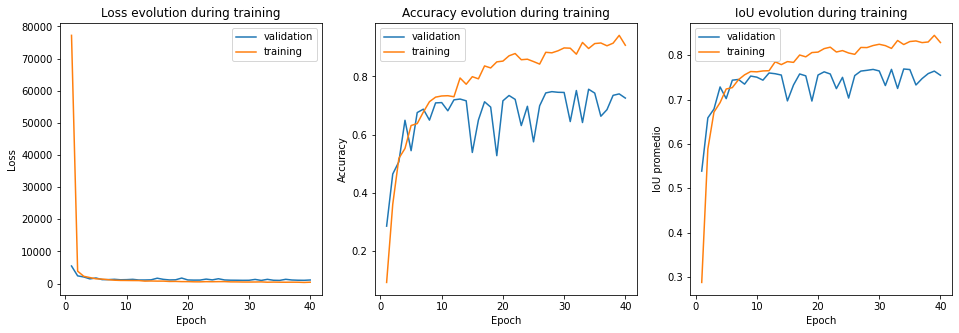

Entrenando corrida número 2/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 528780.9638671875, Train acc: 0.02734375, IoU: 0.047960102675157636
Iteration 22 - Batch 22/70 - Train loss: 314117.863451087, Train acc: 0.022418478260869564, IoU: 0.06073614401632609
Iteration 33 - Batch 33/70 - Train loss: 218779.92302389705, Train acc: 0.04963235294117647, IoU: 0.1550151323377938
Iteration 44 - Batch 44/70 - Train loss: 167466.11767578125, Train acc: 0.058680555555555555, IoU: 0.2062303288439125
Iteration 55 - Batch 55/70 - Train loss: 135754.59296962194, Train acc: 0.10044642857142858, IoU: 0.2700901530942141
Iteration 66 - Batch 66/70 - Train loss: 114222.35711578824, Train acc: 0.13199626865671643, IoU: 0.3148332785886314
Val loss: 3534.084716796875, Val acc: 0.37610619469026546, Val IoU: 0.6087226928032103
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 3559.4646199544272, Train acc: 0.3697916666666667, IoU: 0.5959837470398573
Iteration 92 - Batch 22/70 - Train loss: 3420.1149

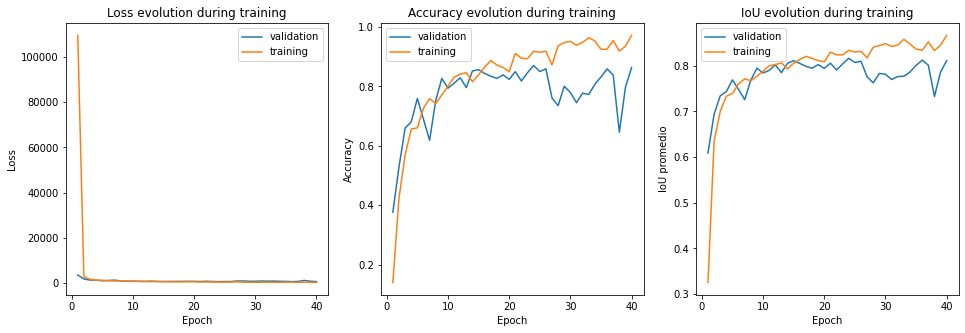

Entrenando corrida número 3/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 635329.6586914062, Train acc: 0.0013020833333333333, IoU: 0.03812545838385025
Iteration 22 - Batch 22/70 - Train loss: 398009.61200747284, Train acc: 0.0006793478260869565, IoU: 0.025187273518341775
Iteration 33 - Batch 33/70 - Train loss: 279456.6209788603, Train acc: 0.03262867647058824, IoU: 0.10740785297506296
Iteration 44 - Batch 44/70 - Train loss: 216028.1865451389, Train acc: 0.04861111111111111, IoU: 0.15192831076722843
Iteration 55 - Batch 55/70 - Train loss: 176803.49874441963, Train acc: 0.06808035714285714, IoU: 0.18875853204953533
Iteration 66 - Batch 66/70 - Train loss: 149964.10536672108, Train acc: 0.08185634328358209, IoU: 0.2170071725925604
Val loss: 10964.6279296875, Val acc: 0.1709070796460177, Val IoU: 0.39129698963481246
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 11603.748291015625, Train acc: 0.1640625, IoU: 0.3687054694512426
Iteration 92 - Batch 22/70 - Train loss: 10989

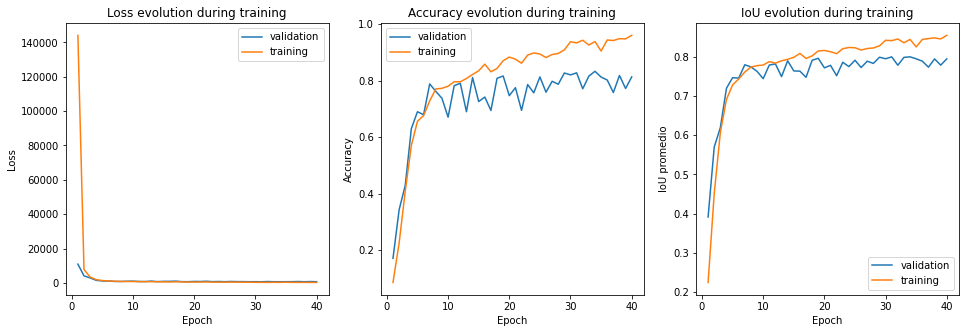

Entrenando corrida número 4/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 403378.56494140625, Train acc: 0.009114583333333334, IoU: 0.02653640317233415
Iteration 22 - Batch 22/70 - Train loss: 295053.74855638586, Train acc: 0.004755434782608696, IoU: 0.013845079916000426
Iteration 33 - Batch 33/70 - Train loss: 231200.27119715072, Train acc: 0.003676470588235294, IoU: 0.017610173546392403
Iteration 44 - Batch 44/70 - Train loss: 180439.08012152778, Train acc: 0.02361111111111111, IoU: 0.08935696915428303
Iteration 55 - Batch 55/70 - Train loss: 148040.21826171875, Train acc: 0.046875, IoU: 0.14191289964370363
Iteration 66 - Batch 66/70 - Train loss: 125699.47083430504, Train acc: 0.057369402985074626, IoU: 0.175263432327334
Val loss: 9564.1103515625, Val acc: 0.1886061946902655, Val IoU: 0.43346394758761153
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 8997.140340169271, Train acc: 0.17057291666666666, IoU: 0.43970559890082467
Iteration 92 - Batch 22/70 - Train loss: 8579

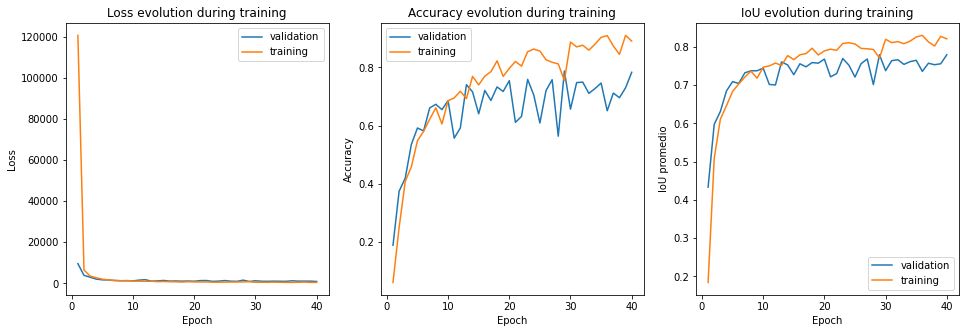

Entrenando corrida número 5/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 362069.2301432292, Train acc: 0.0078125, IoU: 0.03293384284188505
Iteration 22 - Batch 22/70 - Train loss: 249224.74133831522, Train acc: 0.012228260869565218, IoU: 0.042226575299814016
Iteration 33 - Batch 33/70 - Train loss: 176238.26045496322, Train acc: 0.03952205882352941, IoU: 0.11930941693475795
Iteration 44 - Batch 44/70 - Train loss: 136969.63936631943, Train acc: 0.06631944444444444, IoU: 0.1732509201055412
Iteration 55 - Batch 55/70 - Train loss: 112379.67855398996, Train acc: 0.08761160714285714, IoU: 0.21462299590354764
Iteration 66 - Batch 66/70 - Train loss: 95221.61245044309, Train acc: 0.11217350746268656, IoU: 0.2566504470589497
Val loss: 6422.4375, Val acc: 0.25442477876106195, Val IoU: 0.5050619121816574
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 5478.859130859375, Train acc: 0.2721354166666667, IoU: 0.5257835281125457
Iteration 92 - Batch 22/70 - Train loss: 4695.816002887228

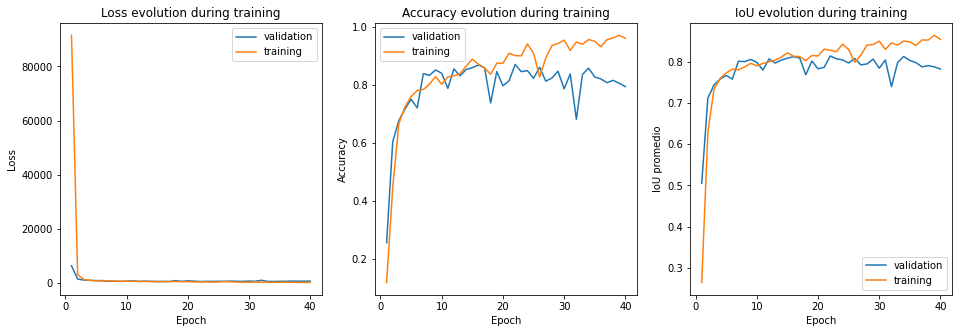

In [ ]:
if not Path('curves_batch_six.pickle').is_file():
  run_n_times = 5
  curves_batch_six = []

  for run in range(run_n_times):
      print(f"Entrenando corrida número {run + 1}/{run_n_times}")
      CNN1d = CNN1d_Model_ninebatch6()
      curves = train_model(
          CNN1d,
          train_ds,
          val_ds,
          epochs,
          criterion,
          batch_size,
          lr,
          metric='IoU',
          use_gpu=True,
          data_augmentation=False,
          delta=0.7
      )
      curves_batch_six.append(curves)
      show_curves(curves, metric, gpu=True)

  pickle.dump(curves_batch_six,open('curves_batch_six.pickle','wb'))

else:
  curves_batch_six=pickle.load(open('curves_batch_six.pickle','rb'))

### Batch Normalization 9 capas

Entrenando corrida número 1/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 175334.26432291666, Train acc: 0.0, IoU: 0.0
Iteration 22 - Batch 22/70 - Train loss: 167429.69157608695, Train acc: 0.0, IoU: 0.0
Iteration 33 - Batch 33/70 - Train loss: 159835.75321691178, Train acc: 0.0, IoU: 0.0
Iteration 44 - Batch 44/70 - Train loss: 147146.8204861111, Train acc: 0.0, IoU: 0.0
Iteration 55 - Batch 55/70 - Train loss: 133108.93994140625, Train acc: 0.0, IoU: 6.554567205187466e-06
Iteration 66 - Batch 66/70 - Train loss: 117370.88768073694, Train acc: 0.0, IoU: 0.0010310893594442628
Val loss: 13338.3935546875, Val acc: 0.0, Val IoU: 0.1104513794801608
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 7758.475565592448, Train acc: 0.0026041666666666665, IoU: 0.24924309387665744
Iteration 92 - Batch 22/70 - Train loss: 5256.4982750934105, Train acc: 0.050951086956521736, IoU: 0.3833983168532264
Iteration 103 - Batch 33/70 - Train loss: 4081.9083593031937, Train acc: 0.173253676470588

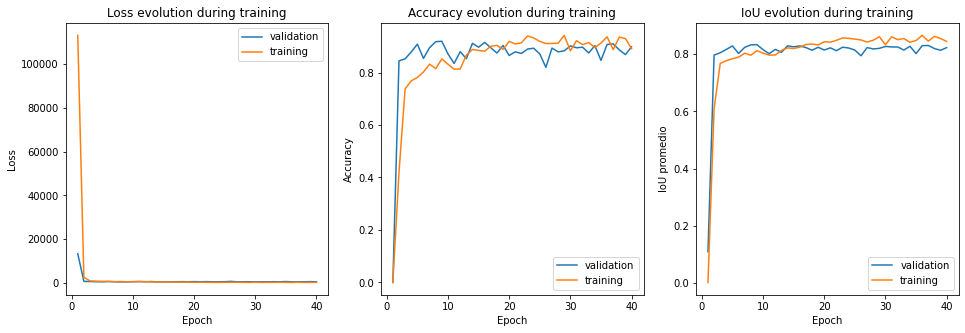

Entrenando corrida número 2/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 168784.90885416666, Train acc: 0.0, IoU: 0.0
Iteration 22 - Batch 22/70 - Train loss: 162729.8926630435, Train acc: 0.0, IoU: 0.0
Iteration 33 - Batch 33/70 - Train loss: 156301.6424632353, Train acc: 0.0, IoU: 0.0
Iteration 44 - Batch 44/70 - Train loss: 145930.79427083334, Train acc: 0.0, IoU: 0.0
Iteration 55 - Batch 55/70 - Train loss: 131308.07205636162, Train acc: 0.0, IoU: 8.776066429813259e-05
Iteration 66 - Batch 66/70 - Train loss: 115441.09100979478, Train acc: 0.0, IoU: 0.0014748446038036274
Val loss: 14835.5029296875, Val acc: 0.0, Val IoU: 0.09049792328588144
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 7825.6964925130205, Train acc: 0.00390625, IoU: 0.2569625878227839
Iteration 92 - Batch 22/70 - Train loss: 5319.2325227156925, Train acc: 0.06929347826086957, IoU: 0.39133168759677456
Iteration 103 - Batch 33/70 - Train loss: 4187.165250890395, Train acc: 0.17647058823529413, IoU: 0.4

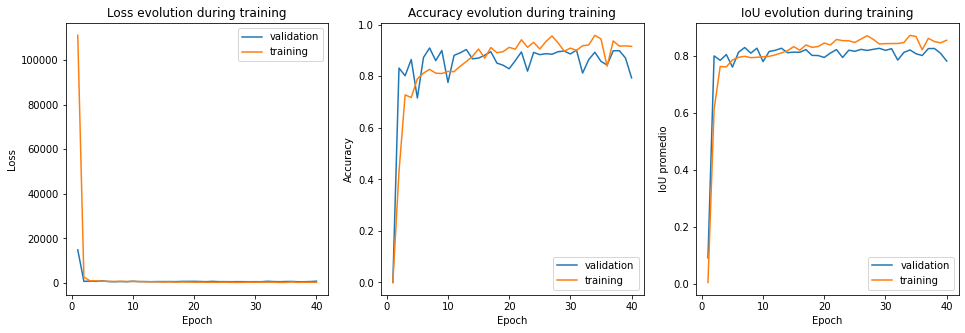

Entrenando corrida número 3/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 168501.0234375, Train acc: 0.0, IoU: 0.0
Iteration 22 - Batch 22/70 - Train loss: 165232.32676630435, Train acc: 0.0, IoU: 0.0
Iteration 33 - Batch 33/70 - Train loss: 157349.00390625, Train acc: 0.0, IoU: 0.0
Iteration 44 - Batch 44/70 - Train loss: 145548.02135416667, Train acc: 0.0, IoU: 0.0
Iteration 55 - Batch 55/70 - Train loss: 131534.48625837054, Train acc: 0.0, IoU: 1.3482922180888376e-05
Iteration 66 - Batch 66/70 - Train loss: 115784.56258745336, Train acc: 0.0, IoU: 0.0010039048118197747
Val loss: 16947.107421875, Val acc: 0.0005530973451327434, Val IoU: 0.08117759123410302
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 8164.4249267578125, Train acc: 0.0078125, IoU: 0.23197033983251458
Iteration 92 - Batch 22/70 - Train loss: 5568.1640678074045, Train acc: 0.042798913043478264, IoU: 0.36436864061698027
Iteration 103 - Batch 33/70 - Train loss: 4394.287823845359, Train acc: 0.1447610294117

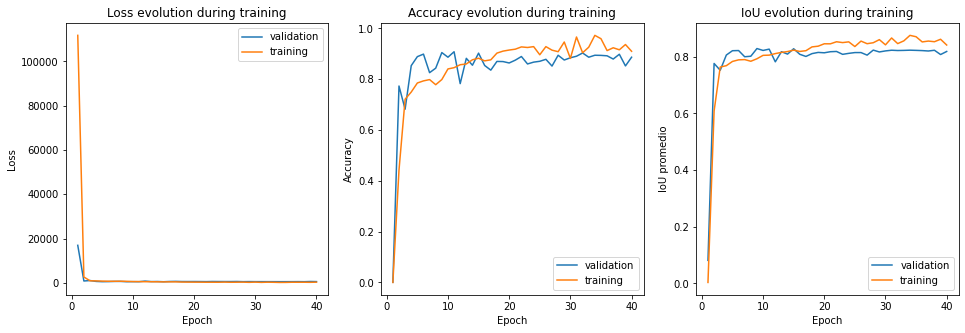

Entrenando corrida número 4/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 168812.67578125, Train acc: 0.0, IoU: 0.0
Iteration 22 - Batch 22/70 - Train loss: 166538.0129076087, Train acc: 0.0, IoU: 0.0
Iteration 33 - Batch 33/70 - Train loss: 159192.5294117647, Train acc: 0.0, IoU: 0.0
Iteration 44 - Batch 44/70 - Train loss: 146739.1144097222, Train acc: 0.0, IoU: 0.0
Iteration 55 - Batch 55/70 - Train loss: 132164.77685546875, Train acc: 0.0, IoU: 1.319121552764305e-05
Iteration 66 - Batch 66/70 - Train loss: 116754.35648903919, Train acc: 0.0, IoU: 0.00135734435948439
Val loss: 14608.0498046875, Val acc: 0.0, Val IoU: 0.08425238432610702
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 7888.946553548177, Train acc: 0.0026041666666666665, IoU: 0.26056876038273913
Iteration 92 - Batch 22/70 - Train loss: 5246.2724609375, Train acc: 0.06317934782608696, IoU: 0.39301576084677514
Iteration 103 - Batch 33/70 - Train loss: 4063.166358498966, Train acc: 0.19806985294117646, IoU: 0

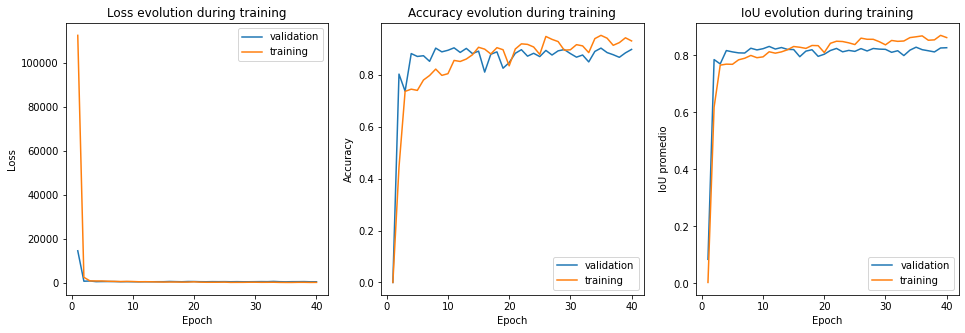

Entrenando corrida número 5/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 175218.01692708334, Train acc: 0.0, IoU: 0.0
Iteration 22 - Batch 22/70 - Train loss: 169571.45244565216, Train acc: 0.0, IoU: 0.0
Iteration 33 - Batch 33/70 - Train loss: 159068.58340992648, Train acc: 0.0, IoU: 0.0
Iteration 44 - Batch 44/70 - Train loss: 147716.58402777778, Train acc: 0.0, IoU: 0.0
Iteration 55 - Batch 55/70 - Train loss: 132464.52315848213, Train acc: 0.0, IoU: 1.2598179247496383e-05
Iteration 66 - Batch 66/70 - Train loss: 116302.17318680037, Train acc: 0.0, IoU: 0.0022354646832504093
Val loss: 14552.54296875, Val acc: 0.0005530973451327434, Val IoU: 0.1305617915376573
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 7997.029561360677, Train acc: 0.006510416666666667, IoU: 0.2658889025886613
Iteration 92 - Batch 22/70 - Train loss: 5412.407895295516, Train acc: 0.06317934782608696, IoU: 0.39791550265181286
Iteration 103 - Batch 33/70 - Train loss: 4174.578203986673, Train acc: 0.1

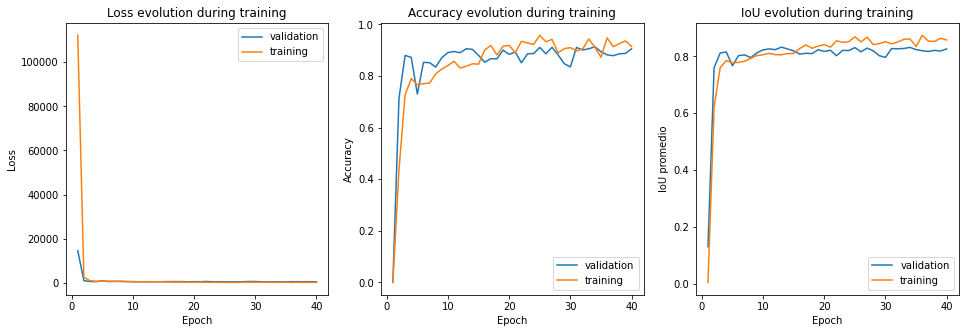

In [ ]:
if not Path('curves_batch_nine.pickle').is_file():
  run_n_times = 5
  curves_batch_nine = []

  for run in range(run_n_times):
      print(f"Entrenando corrida número {run + 1}/{run_n_times}")
      CNN1d = CNN1d_Model_ninebatch9()
      curves = train_model(
          CNN1d,
          train_ds,
          val_ds,
          epochs,
          criterion,
          batch_size,
          lr,
          metric='IoU',
          use_gpu=True,
          data_augmentation=False,
          delta=0.7
      )
      curves_batch_nine.append(curves)
      show_curves(curves, metric, gpu=True)

  pickle.dump(curves_batch_nine,open('curves_batch_nine.pickle','wb'))

else:
  curves_batch_nine=pickle.load(open('curves_batch_nine.pickle','rb'))

## Learning Rate

### lr=0.0001

Entrenando corrida número 1/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 175825.640625, Train acc: 0.0, IoU: 0.0
Iteration 22 - Batch 22/70 - Train loss: 178889.00815217392, Train acc: 0.0, IoU: 0.0
Iteration 33 - Batch 33/70 - Train loss: 177674.8010110294, Train acc: 0.0, IoU: 0.0
Iteration 44 - Batch 44/70 - Train loss: 176889.02673611112, Train acc: 0.0, IoU: 0.0
Iteration 55 - Batch 55/70 - Train loss: 175477.29659598213, Train acc: 0.0, IoU: 0.0
Iteration 66 - Batch 66/70 - Train loss: 174932.97854477612, Train acc: 0.0, IoU: 0.0
Val loss: 174187.578125, Val acc: 0.0, Val IoU: 0.0
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 176417.92317708334, Train acc: 0.0, IoU: 0.0
Iteration 92 - Batch 22/70 - Train loss: 173122.47554347827, Train acc: 0.0, IoU: 0.0
Iteration 103 - Batch 33/70 - Train loss: 174816.33455882352, Train acc: 0.0, IoU: 0.0
Iteration 114 - Batch 44/70 - Train loss: 172660.3138888889, Train acc: 0.0, IoU: 0.0
Iteration 125 - Batch 55/70 - Train loss:

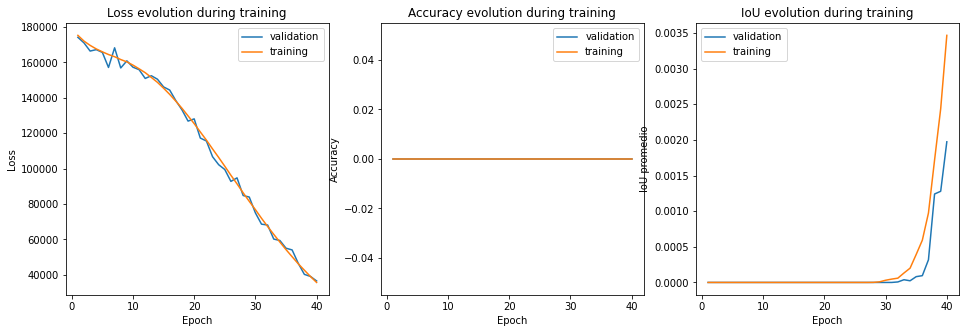

Entrenando corrida número 2/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 176452.09244791666, Train acc: 0.0, IoU: 0.0
Iteration 22 - Batch 22/70 - Train loss: 176311.61480978262, Train acc: 0.0, IoU: 0.0
Iteration 33 - Batch 33/70 - Train loss: 174837.46231617648, Train acc: 0.0, IoU: 0.0
Iteration 44 - Batch 44/70 - Train loss: 174064.13611111112, Train acc: 0.0, IoU: 0.0
Iteration 55 - Batch 55/70 - Train loss: 175015.9076450893, Train acc: 0.0, IoU: 0.0
Iteration 66 - Batch 66/70 - Train loss: 175225.4780783582, Train acc: 0.0, IoU: 0.0
Val loss: 172874.296875, Val acc: 0.0, Val IoU: 0.0
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 174632.5625, Train acc: 0.0, IoU: 0.0
Iteration 92 - Batch 22/70 - Train loss: 174050.20652173914, Train acc: 0.0, IoU: 0.0
Iteration 103 - Batch 33/70 - Train loss: 172156.70404411765, Train acc: 0.0, IoU: 0.0
Iteration 114 - Batch 44/70 - Train loss: 172141.78715277778, Train acc: 0.0, IoU: 0.0
Iteration 125 - Batch 55/70 - Train loss: 1

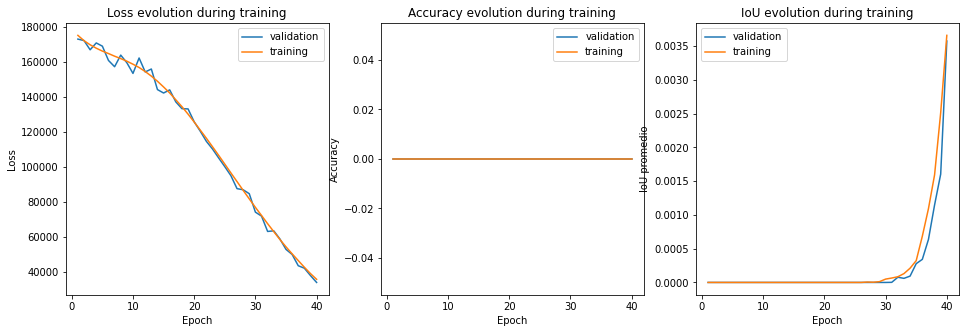

Entrenando corrida número 3/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 174183.04036458334, Train acc: 0.0, IoU: 0.0
Iteration 22 - Batch 22/70 - Train loss: 177517.21059782608, Train acc: 0.0, IoU: 0.0
Iteration 33 - Batch 33/70 - Train loss: 176021.4296875, Train acc: 0.0, IoU: 0.0
Iteration 44 - Batch 44/70 - Train loss: 174741.775, Train acc: 0.0, IoU: 0.0
Iteration 55 - Batch 55/70 - Train loss: 175348.89174107142, Train acc: 0.0, IoU: 0.0
Iteration 66 - Batch 66/70 - Train loss: 175156.40321828358, Train acc: 0.0, IoU: 0.0
Val loss: 173923.890625, Val acc: 0.0, Val IoU: 0.0
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 168779.8203125, Train acc: 0.0, IoU: 0.0
Iteration 92 - Batch 22/70 - Train loss: 171438.69157608695, Train acc: 0.0, IoU: 0.0
Iteration 103 - Batch 33/70 - Train loss: 171082.53079044117, Train acc: 0.0, IoU: 0.0
Iteration 114 - Batch 44/70 - Train loss: 171429.64652777778, Train acc: 0.0, IoU: 0.0
Iteration 125 - Batch 55/70 - Train loss: 171921.5

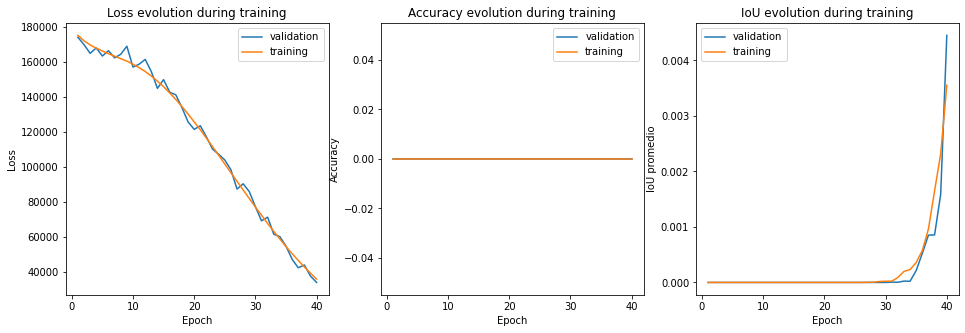

Entrenando corrida número 4/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 177445.65104166666, Train acc: 0.0, IoU: 0.0
Iteration 22 - Batch 22/70 - Train loss: 176014.55502717392, Train acc: 0.0, IoU: 0.0
Iteration 33 - Batch 33/70 - Train loss: 176109.89200367648, Train acc: 0.0, IoU: 0.0
Iteration 44 - Batch 44/70 - Train loss: 175367.92361111112, Train acc: 0.0, IoU: 0.0
Iteration 55 - Batch 55/70 - Train loss: 175123.6489955357, Train acc: 0.0, IoU: 0.0
Iteration 66 - Batch 66/70 - Train loss: 174944.29197761195, Train acc: 0.0, IoU: 0.0
Val loss: 173789.390625, Val acc: 0.0, Val IoU: 0.0
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 177184.5625, Train acc: 0.0, IoU: 0.0
Iteration 92 - Batch 22/70 - Train loss: 174334.81997282608, Train acc: 0.0, IoU: 0.0
Iteration 103 - Batch 33/70 - Train loss: 172320.0799632353, Train acc: 0.0, IoU: 0.0
Iteration 114 - Batch 44/70 - Train loss: 171758.4246527778, Train acc: 0.0, IoU: 0.0
Iteration 125 - Batch 55/70 - Train loss: 17

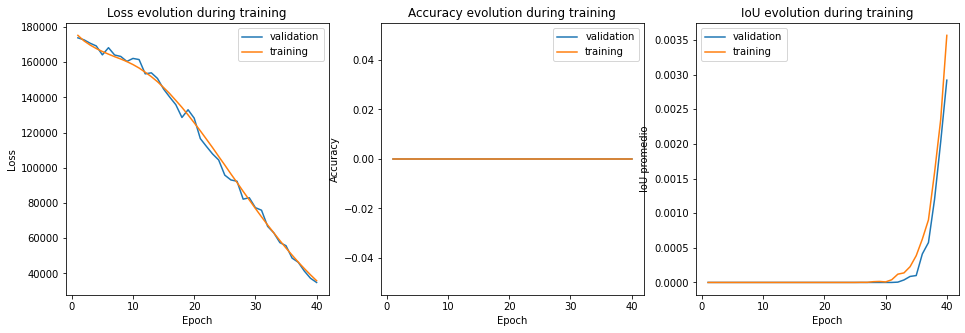

Entrenando corrida número 5/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 181300.42447916666, Train acc: 0.0, IoU: 0.0
Iteration 22 - Batch 22/70 - Train loss: 177768.7010869565, Train acc: 0.0, IoU: 0.0
Iteration 33 - Batch 33/70 - Train loss: 178763.43106617648, Train acc: 0.0, IoU: 0.0
Iteration 44 - Batch 44/70 - Train loss: 177227.36145833333, Train acc: 0.0, IoU: 0.0
Iteration 55 - Batch 55/70 - Train loss: 176550.58677455358, Train acc: 0.0, IoU: 0.0
Iteration 66 - Batch 66/70 - Train loss: 175501.47061567163, Train acc: 0.0, IoU: 0.0
Val loss: 172229.4375, Val acc: 0.0, Val IoU: 0.0
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 174023.93880208334, Train acc: 0.0, IoU: 0.0
Iteration 92 - Batch 22/70 - Train loss: 173808.91508152173, Train acc: 0.0, IoU: 0.0
Iteration 103 - Batch 33/70 - Train loss: 173539.2559742647, Train acc: 0.0, IoU: 0.0
Iteration 114 - Batch 44/70 - Train loss: 172731.409375, Train acc: 0.0, IoU: 0.0
Iteration 125 - Batch 55/70 - Train loss: 1

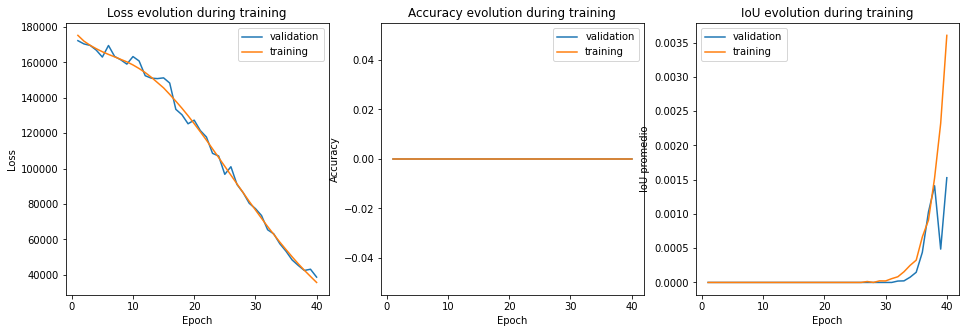

In [ ]:
if not Path('curves_batch_nine_lr1e_4.pickle').is_file():
  run_n_times = 5

  curves_batch_nine_lr1e_4=[]

  for run in range(run_n_times):
      print(f"Entrenando corrida número {run + 1}/{run_n_times}")
      CNN1d = CNN1d_Model_ninebatch9()
      curves = train_model(
          CNN1d,
          train_ds,
          val_ds,
          epochs,
          criterion,
          batch_size,
          0.0001,
          metric='IoU',
          use_gpu=True,
          data_augmentation=False,
          delta=0.7
      )
      curves_batch_nine_lr1e_4.append(curves)
      show_curves(curves, metric, gpu=True)

  pickle.dump(curves_batch_nine_lr1e_4,open('curves_batch_nine_lr1e_4.pickle','wb'))

else:
  curves_batch_nine_lr1e_4=pickle.load(open('curves_batch_nine_lr1e_4.pickle','rb'))

### lr=0.001

Entrenando corrida número 1/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 175179.63020833334, Train acc: 0.0, IoU: 0.0
Iteration 22 - Batch 22/70 - Train loss: 172850.140625, Train acc: 0.0, IoU: 0.0
Iteration 33 - Batch 33/70 - Train loss: 172279.02205882352, Train acc: 0.0, IoU: 0.0
Iteration 44 - Batch 44/70 - Train loss: 170206.709375, Train acc: 0.0, IoU: 0.0
Iteration 55 - Batch 55/70 - Train loss: 169044.87416294642, Train acc: 0.0, IoU: 0.0
Iteration 66 - Batch 66/70 - Train loss: 167617.25233208956, Train acc: 0.0, IoU: 0.0
Val loss: 168039.453125, Val acc: 0.0, Val IoU: 0.0
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 161710.94401041666, Train acc: 0.0, IoU: 0.0
Iteration 92 - Batch 22/70 - Train loss: 157869.19157608695, Train acc: 0.0, IoU: 0.0
Iteration 103 - Batch 33/70 - Train loss: 155712.24310661765, Train acc: 0.0, IoU: 0.0
Iteration 114 - Batch 44/70 - Train loss: 153370.67256944443, Train acc: 0.0, IoU: 0.0
Iteration 125 - Batch 55/70 - Train loss: 15

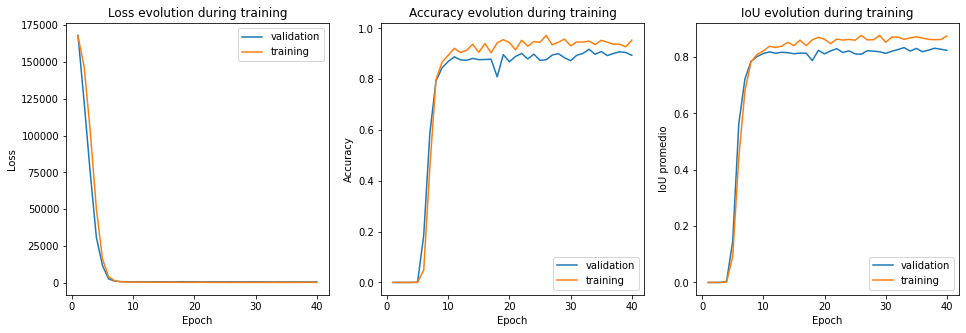

Entrenando corrida número 2/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 178082.42447916666, Train acc: 0.0, IoU: 0.0
Iteration 22 - Batch 22/70 - Train loss: 173627.12975543478, Train acc: 0.0, IoU: 0.0
Iteration 33 - Batch 33/70 - Train loss: 172040.55790441178, Train acc: 0.0, IoU: 0.0
Iteration 44 - Batch 44/70 - Train loss: 171322.01527777777, Train acc: 0.0, IoU: 0.0
Iteration 55 - Batch 55/70 - Train loss: 169150.72823660713, Train acc: 0.0, IoU: 0.0
Iteration 66 - Batch 66/70 - Train loss: 167489.58162313432, Train acc: 0.0, IoU: 0.0
Val loss: 172546.109375, Val acc: 0.0, Val IoU: 0.0
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 154266.61197916666, Train acc: 0.0, IoU: 0.0
Iteration 92 - Batch 22/70 - Train loss: 155857.3152173913, Train acc: 0.0, IoU: 0.0
Iteration 103 - Batch 33/70 - Train loss: 153081.35661764705, Train acc: 0.0, IoU: 0.0
Iteration 114 - Batch 44/70 - Train loss: 151249.02534722222, Train acc: 0.0, IoU: 0.0
Iteration 125 - Batch 55/70 - Train

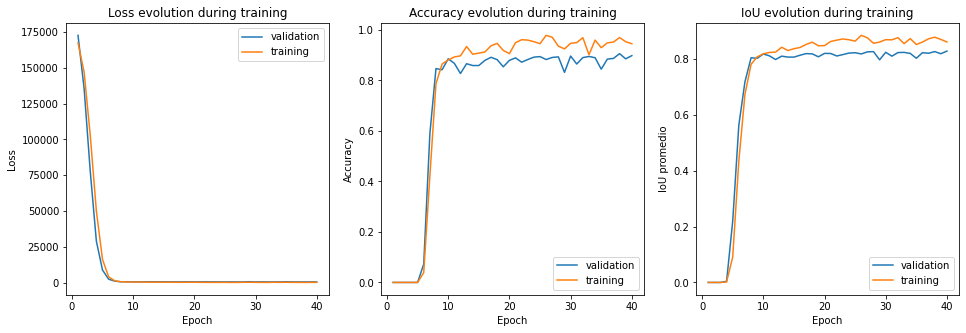

Entrenando corrida número 3/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 176386.56640625, Train acc: 0.0, IoU: 0.0
Iteration 22 - Batch 22/70 - Train loss: 174122.25951086957, Train acc: 0.0, IoU: 0.0
Iteration 33 - Batch 33/70 - Train loss: 173237.39108455883, Train acc: 0.0, IoU: 0.0
Iteration 44 - Batch 44/70 - Train loss: 171385.8621527778, Train acc: 0.0, IoU: 0.0
Iteration 55 - Batch 55/70 - Train loss: 169202.93136160713, Train acc: 0.0, IoU: 0.0
Iteration 66 - Batch 66/70 - Train loss: 167679.2416044776, Train acc: 0.0, IoU: 0.0
Val loss: 161252.546875, Val acc: 0.0, Val IoU: 0.0
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 155498.08854166666, Train acc: 0.0, IoU: 0.0
Iteration 92 - Batch 22/70 - Train loss: 156375.24524456522, Train acc: 0.0, IoU: 0.0
Iteration 103 - Batch 33/70 - Train loss: 154528.88740808822, Train acc: 0.0, IoU: 0.0
Iteration 114 - Batch 44/70 - Train loss: 151761.17274305556, Train acc: 0.0, IoU: 0.0
Iteration 125 - Batch 55/70 - Train los

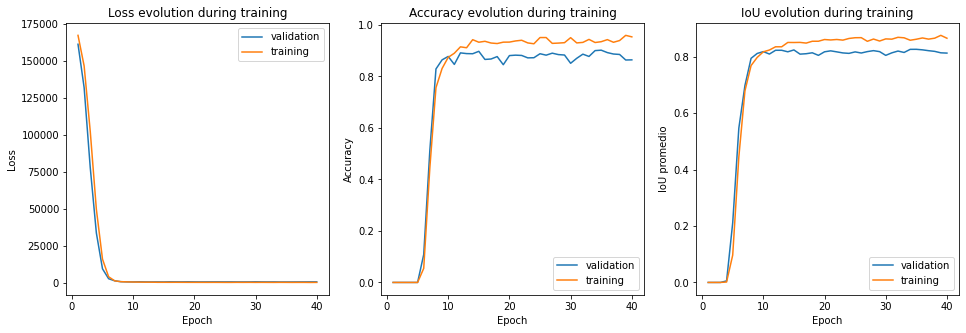

Entrenando corrida número 4/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 174682.14322916666, Train acc: 0.0, IoU: 0.0
Iteration 22 - Batch 22/70 - Train loss: 173631.30502717392, Train acc: 0.0, IoU: 0.0
Iteration 33 - Batch 33/70 - Train loss: 170411.93290441178, Train acc: 0.0, IoU: 0.0
Iteration 44 - Batch 44/70 - Train loss: 169805.42569444445, Train acc: 0.0, IoU: 0.0
Iteration 55 - Batch 55/70 - Train loss: 167811.75083705358, Train acc: 0.0, IoU: 0.0
Iteration 66 - Batch 66/70 - Train loss: 167460.3640391791, Train acc: 0.0, IoU: 0.0
Val loss: 152296.53125, Val acc: 0.0, Val IoU: 0.0
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 155715.8515625, Train acc: 0.0, IoU: 0.0
Iteration 92 - Batch 22/70 - Train loss: 157566.22554347827, Train acc: 0.0, IoU: 0.0
Iteration 103 - Batch 33/70 - Train loss: 155013.1286764706, Train acc: 0.0, IoU: 0.0
Iteration 114 - Batch 44/70 - Train loss: 152706.09913194444, Train acc: 0.0, IoU: 0.0
Iteration 125 - Batch 55/70 - Train loss:

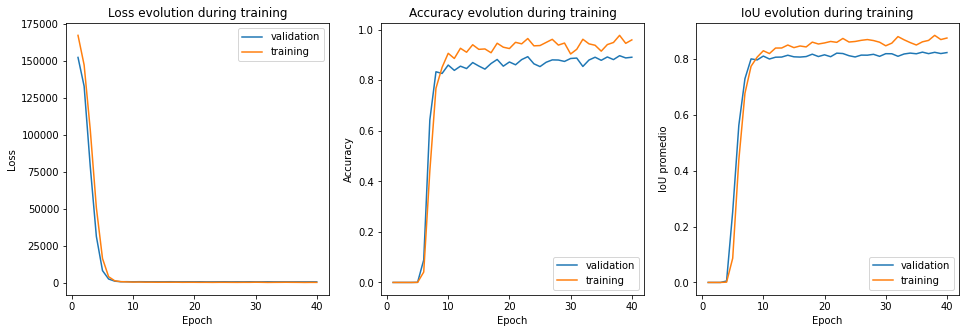

Entrenando corrida número 5/5
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 173431.43489583334, Train acc: 0.0, IoU: 0.0
Iteration 22 - Batch 22/70 - Train loss: 171156.05774456522, Train acc: 0.0, IoU: 0.0
Iteration 33 - Batch 33/70 - Train loss: 170408.31295955883, Train acc: 0.0, IoU: 0.0
Iteration 44 - Batch 44/70 - Train loss: 170250.3267361111, Train acc: 0.0, IoU: 0.0
Iteration 55 - Batch 55/70 - Train loss: 168664.1967075893, Train acc: 0.0, IoU: 0.0
Iteration 66 - Batch 66/70 - Train loss: 167412.78125, Train acc: 0.0, IoU: 0.0
Val loss: 170801.796875, Val acc: 0.0, Val IoU: 0.0
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 156979.72916666666, Train acc: 0.0, IoU: 0.0
Iteration 92 - Batch 22/70 - Train loss: 155483.37975543478, Train acc: 0.0, IoU: 0.0
Iteration 103 - Batch 33/70 - Train loss: 152657.55330882352, Train acc: 0.0, IoU: 0.0
Iteration 114 - Batch 44/70 - Train loss: 151728.5027777778, Train acc: 0.0, IoU: 0.0
Iteration 125 - Batch 55/70 - Train loss: 1

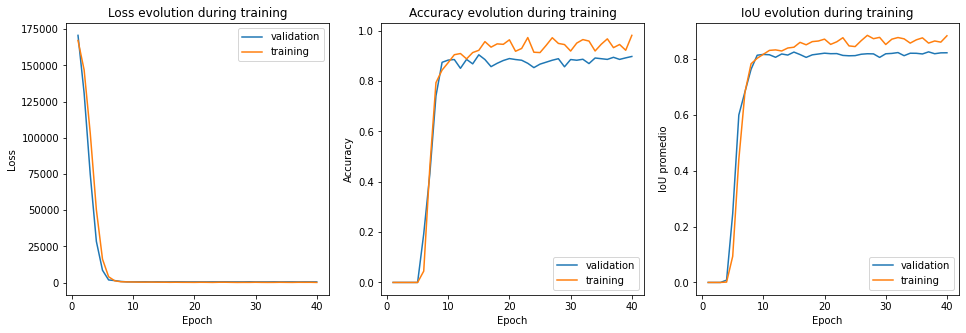

In [ ]:
if not Path('curves_batch_nine_lr1e_3.pickle').is_file():
  run_n_times = 5

  curves_batch_nine_lr1e_3=[]

  for run in range(run_n_times):
      print(f"Entrenando corrida número {run + 1}/{run_n_times}")
      CNN1d = CNN1d_Model_ninebatch9()
      curves = train_model(
          CNN1d,
          train_ds,
          val_ds,
          epochs,
          criterion,
          batch_size,
          0.001,
          metric='IoU',
          use_gpu=True,
          data_augmentation=False,
          delta=0.7
      )
      curves_batch_nine_lr1e_3.append(curves)
      show_curves(curves, metric, gpu=True)

  pickle.dump(curves_batch_nine_lr1e_3,open('curves_batch_nine_lr1e_3.pickle','wb'))

else:
  curves_batch_nine_lr1e_3=pickle.load(open('curves_batch_nine_lr1e_3.pickle','rb'))

### lr=0.01

In [ ]:
if not Path('curves_batch_nine_lr1e_2.pickle').is_file():
  run_n_times = 5

  curves_batch_nine_lr1e_2=[]

  for run in range(run_n_times):
      print(f"Entrenando corrida número {run + 1}/{run_n_times}")
      CNN1d = CNN1d_Model_ninebatch9()
      curves = train_model(
          CNN1d,
          train_ds,
          val_ds,
          epochs,
          criterion,
          batch_size,
          0.01,
          metric='IoU',
          use_gpu=True,
          data_augmentation=False,
          delta=0.7
      )
      curves_batch_nine_lr1e_2.append(curves)
      show_curves(curves, metric, gpu=True)

  pickle.dump(curves_batch_nine_lr1e_2,open('curves_batch_nine_lr1e_2.pickle','wb'))

else:
  curves_batch_nine_lr1e_2=pickle.load(open('curves_batch_nine_lr1e_2.pickle','rb'))

### lr = 0.1

In [ ]:
if not Path('curves_batch_nine_lr1e_1.pickle').is_file():
  run_n_times = 5

  curves_batch_nine_lr1e_1=[]

  for run in range(run_n_times):
      print(f"Entrenando corrida número {run + 1}/{run_n_times}")
      CNN1d = CNN1d_Model_ninebatch9()
      curves = train_model(
          CNN1d,
          train_ds,
          val_ds,
          epochs,
          criterion,
          batch_size,
          0.1,
          metric='IoU',
          use_gpu=True,
          data_augmentation=False,
          delta=0.7
      )
      curves_batch_nine_lr1e_1.append(curves)
      show_curves(curves, metric, gpu=True)

  pickle.dump(curves_batch_nine_lr1e_1,open('curves_batch_nine_lr1e_1.pickle','wb'))

else:
  curves_batch_nine_lr1e_1=pickle.load(open('curves_batch_nine_lr1e_1.pickle','rb'))

# Resultados

## n° bloques convolucionales

In [ ]:
print('Número de bloques = 3:')
val_acc_history = np.array([run['val_acc'][-1] for run in curves_three])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print(' Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))

train_acc_history = np.array([run['train_acc'][-1] for run in curves_three])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print(' Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print()

print('Número de bloques = 5:')
val_acc_history = np.array([run['val_acc'][-1] for run in curves_five])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print(' Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))

train_acc_history = np.array([run['train_acc'][-1] for run in curves_five])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print(' Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print()

print('Número de bloques = 7:')
val_acc_history = np.array([run['val_acc'][-1] for run in curves_seven])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print(' Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))

train_acc_history = np.array([run['train_acc'][-1] for run in curves_seven])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print(' Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print()

print('Número de bloques = 9:')
val_acc_history = np.array([run['val_acc'][-1] for run in curves_nine])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print(' Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))

train_acc_history = np.array([run['train_acc'][-1] for run in curves_nine])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print(' Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print()

Número de bloques = 3:
 Final validation accuracy 0.553 +/- 0.024
 Final train accuracy 0.558 +/- 0.015

Número de bloques = 5:
 Final validation accuracy 0.648 +/- 0.035
 Final train accuracy 0.594 +/- 0.025

Número de bloques = 7:
 Final validation accuracy 0.709 +/- 0.083
 Final train accuracy 0.691 +/- 0.067

Número de bloques = 9:
 Final validation accuracy 0.854 +/- 0.031
 Final train accuracy 0.867 +/- 0.031



## Tamaño del kernel 

In [ ]:
print('kernel_size = 2:')
val_acc_history = np.array([run['val_acc'][-1] for run in k_size_2_curves])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print(' Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))

train_acc_history = np.array([run['train_acc'][-1] for run in k_size_2_curves])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print(' Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print()

print('kernel_size = 3:')
val_acc_history = np.array([run['val_acc'][-1] for run in k_size_3_curves])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print(' Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))

train_acc_history = np.array([run['train_acc'][-1] for run in k_size_3_curves])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print(' Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print()

print('kernel_size = 4:')
val_acc_history = np.array([run['val_acc'][-1] for run in k_size_4_curves])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print(' Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))

train_acc_history = np.array([run['train_acc'][-1] for run in k_size_4_curves])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print(' Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print()

print('kernel_size = 5:')
val_acc_history = np.array([run['val_acc'][-1] for run in k_size_5_curves])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print(' Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))

train_acc_history = np.array([run['train_acc'][-1] for run in k_size_5_curves])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print(' Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print()

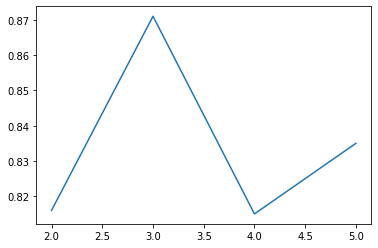

In [ ]:
kernel=[2,3,4,5]
validation=[0.816,0.871,0.815,0.835]
plt.plot(kernel,validation)
plt.xlabel=('Kernel')
plt.ylabel=('validation accuracy')

## Batch Normalization

In [ ]:
print('batch normalization en 1 capa:')
val_acc_history = np.array([run['val_acc'][-1] for run in curves_batch_one])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print(' Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))

train_acc_history = np.array([run['train_acc'][-1] for run in curves_batch_one])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print(' Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print()

print('batch normalization en 3 capas:')
val_acc_history = np.array([run['val_acc'][-1] for run in curves_batch_three])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print(' Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))

train_acc_history = np.array([run['train_acc'][-1] for run in curves_batch_three])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print(' Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print()

print('batch normalization en 6 capas:')
val_acc_history = np.array([run['val_acc'][-1] for run in curves_batch_six])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print(' Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))

train_acc_history = np.array([run['train_acc'][-1] for run in curves_batch_six])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print(' Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print()

print('batch normalization en 9 capas:')
val_acc_history = np.array([run['val_acc'][-1] for run in curves_batch_nine])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print(' Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))

train_acc_history = np.array([run['train_acc'][-1] for run in curves_batch_nine])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print(' Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print()

batch normalization en 1 capa:
 Final validation accuracy 0.836 +/- 0.096
 Final train accuracy 0.860 +/- 0.058

batch normalization en 3 capas:
 Final validation accuracy 0.851 +/- 0.012
 Final train accuracy 0.846 +/- 0.020

batch normalization en 6 capas:
 Final validation accuracy 0.796 +/- 0.045
 Final train accuracy 0.938 +/- 0.033

batch normalization en 9 capas:
 Final validation accuracy 0.876 +/- 0.042
 Final train accuracy 0.912 +/- 0.013



Text(0.5, 1.0, 'Modelo 9 capas convolucionales variando capa de batch normalization')

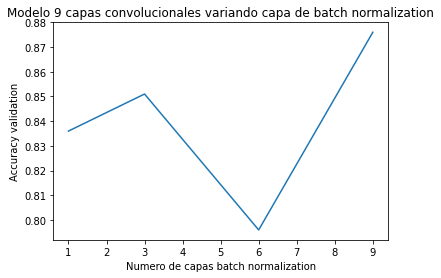

In [ ]:
capas=[1,3,6,9]
validation=[0.836,0.851 ,0.796,0.876  ]
plt.plot(capas,validation)
plt.xlabel("Numero de capas batch normalization")
plt.ylabel("Accuracy validation")
plt.title("Modelo 9 capas convolucionales variando capa de batch normalization")

## Learning Rate

In [ ]:
print('learning rate = 0.0001:')
val_acc_history = np.array([run['val_acc'][-1] for run in curves_batch_nine_lr1e_4])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print(' Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))

train_acc_history = np.array([run['train_acc'][-1] for run in curves_batch_nine_lr1e_4])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print(' Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print()

print('learning rate = 0.001:')
val_acc_history = np.array([run['val_acc'][-1] for run in curves_batch_nine_lr1e_3])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print(' Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))

train_acc_history = np.array([run['train_acc'][-1] for run in curves_batch_nine_lr1e_3])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print(' Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print()

# print('learning rate = 0.01:')
# val_acc_history = np.array([run['val_acc'][-1] for run in curves_batch_nine_lr1e_2])
# val_acc_mean = val_acc_history.mean()
# val_acc_std = val_acc_history.std()
# print(' Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))

# train_acc_history = np.array([run['train_acc'][-1] for run in curves_batch_nine_lr1e_2])
# train_acc_mean = train_acc_history.mean()
# train_acc_std = train_acc_history.std()
# print(' Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
# print()

# print('learning rate = 0.1:')
# val_acc_history = np.array([run['val_acc'][-1] for run in curves_batch_nine_lr1e_1])
# val_acc_mean = val_acc_history.mean()
# val_acc_std = val_acc_history.std()
# print(' Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))

# train_acc_history = np.array([run['train_acc'][-1] for run in curves_batch_nine_lr1e_1])
# train_acc_mean = train_acc_history.mean()
# train_acc_std = train_acc_history.std()
# print(' Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
# print()

learning rate = 0.0001:
 Final validation accuracy 0.000 +/- 0.000
 Final train accuracy 0.000 +/- 0.000

learning rate = 0.001:
 Final validation accuracy 0.889 +/- 0.013
 Final train accuracy 0.959 +/- 0.012



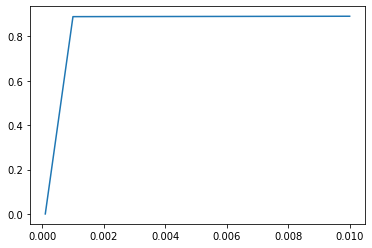

In [ ]:
validation=[0, 0.889,0.89081]
lr=[0.0001,0.001,0.01]
plt.plot(lr,validation)
plt.xlabel=('Learning Rate')
plt.ylabel=('Validation Accuracy')


## Dice Score Mejor modelo 9 capas, 9 batch normalization lr=0.001

Entrenando corrida número 1/1
Epoch 1/40
Iteration 11 - Batch 11/70 - Train loss: 172682.47916666666, Train acc: 0.0, Dice Score: 0.0
Iteration 22 - Batch 22/70 - Train loss: 171956.93002717392, Train acc: 0.0, Dice Score: 0.0
Iteration 33 - Batch 33/70 - Train loss: 169942.18841911765, Train acc: 0.0, Dice Score: 0.0
Iteration 44 - Batch 44/70 - Train loss: 168038.2357638889, Train acc: 0.0, Dice Score: 0.0
Iteration 55 - Batch 55/70 - Train loss: 167644.60714285713, Train acc: 0.0, Dice Score: 0.0
Iteration 66 - Batch 66/70 - Train loss: 167419.7749533582, Train acc: 0.0, Dice Score: 0.0
Val loss: 173726.828125, Val acc: 0.0, Val Dice Score: 0.0
Epoch 2/40
Iteration 81 - Batch 11/70 - Train loss: 160853.16015625, Train acc: 0.0, Dice Score: 0.0
Iteration 92 - Batch 22/70 - Train loss: 157950.47010869565, Train acc: 0.0, Dice Score: 0.0
Iteration 103 - Batch 33/70 - Train loss: 156108.52849264705, Train acc: 0.0, Dice Score: 0.0
Iteration 114 - Batch 44/70 - Train loss: 153275.8809027

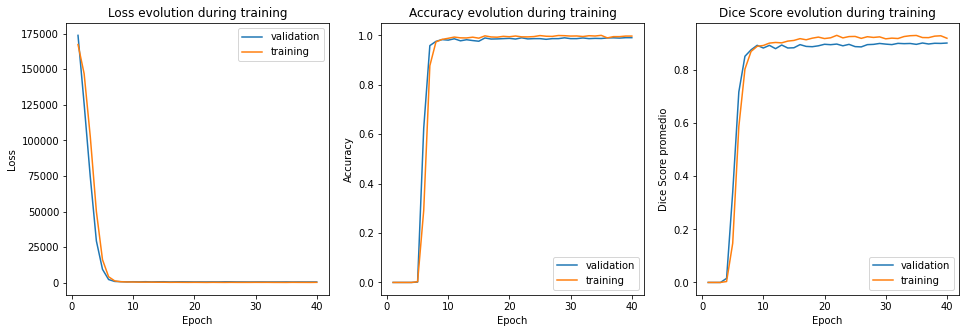

In [ ]:
if not Path('curves_batch_nine_lr1e_3DICESCORE.pickle').is_file() and not Path('Modelbatch_nine_lr1e_3DICESCORE.pickle').is_file():
  run_n_times = 1

  curves_batch_nine_lr1e_3DICESCORE=[]
  Modelbatch_nine_lr1e_3DICESCORE=None
  for run in range(run_n_times):
      print(f"Entrenando corrida número {run + 1}/{run_n_times}")
      CNN1d = CNN1d_Model_ninebatch9()
      curves = train_model(
          CNN1d,
          train_ds,
          val_ds,
          epochs,
          criterion,
          batch_size,
          0.001,
          metric='Dice Score',
          use_gpu=True,
          data_augmentation=False,
          delta=0.7
      )
      curves_batch_nine_lr1e_3DICESCORE.append(curves)
      Modelbatch_nine_lr1e_3DICESCORE=CNN1d
      show_curves(curves, 'Dice Score', gpu=True)

  pickle.dump(curves_batch_nine_lr1e_3DICESCORE,open('curves_batch_nine_lr1e_3DICESCORE.pickle','wb'))
  pickle.dump(Modelbatch_nine_lr1e_3DICESCORE,open('Modelbatch_nine_lr1e_3DICESCORE.pickle','wb'))

else:
  curves_batch_nine_lr1e_3DICESCORE=pickle.load(open('curves_batch_nine_lr1e_3DICESCORE.pickle','rb'))
  Modelbatch_nine_lr1e_3DICESCORE=pickle.load(open('Modelbatch_nine_lr1e_3DICESCORE.pickle','rb'))

# Predicciones del modelo

In [ ]:
def Postprocesamiento(y_predicted):
  y_predicted = torch.round(y_predicted)                               #valores enteros  -> produce el problema de que se predicen puros 0's
  y_predicted = torch.sort(y_predicted).values                         #valor inicial menor que valor final

  #y_predicted = torch.nn.functional.relu(y_predicted, inplace=False)   #valores positivos
  y_predicted[y_predicted < 0] = 0
  y_predicted[y_predicted > 800] = 800                                 #valores menores que 800

  return y_predicted

In [ ]:
predicciones = CNN1d(test_signals.unsqueeze(1)[:4]).detach()

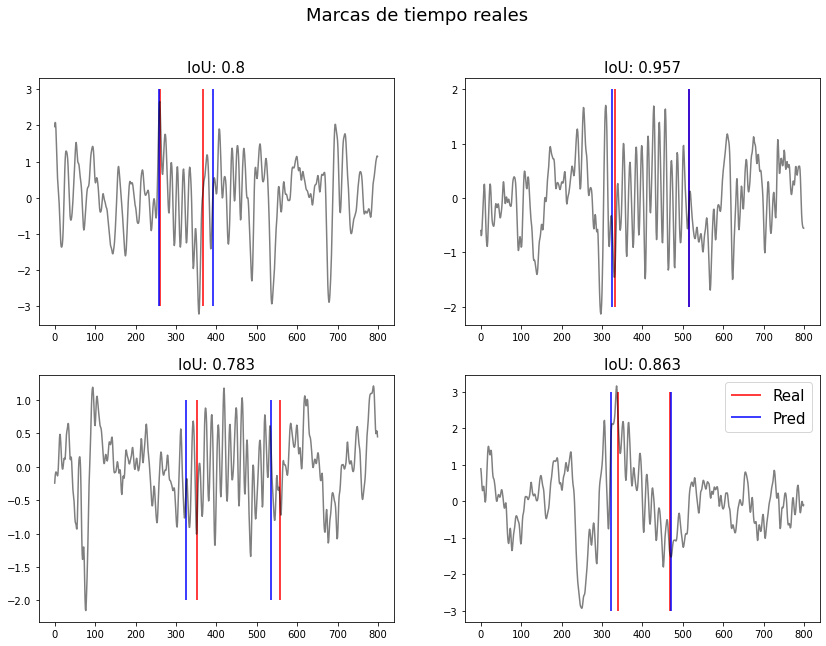

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14,10))

t = np.arange(800)
axs[0, 0].plot(t, test_signals[0], c='black', alpha=0.5)
l1 = axs[0, 0].vlines(test_marks[0], -3, 3, colors='r')
l2 = axs[0, 0].vlines(predicciones[0], -3, 3, colors='b')
axs[0, 0].set_title('IoU: ' + str(round(iou_pytorch(test_marks[0].unsqueeze(0),predicciones[0].unsqueeze(0)).item(),3)), size=15)

axs[0, 1].plot(t, test_signals[1], c='black', alpha=0.5)
axs[0, 1].vlines(test_marks[1], -2, 2, colors='r')
axs[0, 1].vlines(predicciones[1], -2, 2, colors='b')
axs[0, 1].set_title('IoU: ' + str(round(iou_pytorch(test_marks[1].unsqueeze(0),predicciones[1].unsqueeze(0)).item(),3)), size=15)

axs[1, 0].plot(t, test_signals[2], c='black', alpha=0.5)
axs[1, 0].vlines(test_marks[2], -2, 1, colors='r')
axs[1, 0].vlines(predicciones[2], -2, 1, colors='b')
axs[1, 0].set_title('IoU: ' + str(round(iou_pytorch(test_marks[2].unsqueeze(0),predicciones[2].unsqueeze(0)).item(),3)), size=15)

plt.legend([l1, l2],["HHZ 1", "HHN"])

axs[1, 1].plot(t, test_signals[3], c='black', alpha=0.5)
axs[1, 1].vlines(test_marks[3], -3, 3, colors='r')
axs[1, 1].vlines(predicciones[3], -3, 3, colors='b')
axs[1, 1].set_title('IoU: ' + str(round(iou_pytorch(test_marks[3].unsqueeze(0),predicciones[3].unsqueeze(0)).item(),3)), size=15)

plt.legend([l1, l2],["Real", "Pred"], prop={'size': 15})
fig.suptitle('Marcas de tiempo reales', fontsize=18)
fig.show()

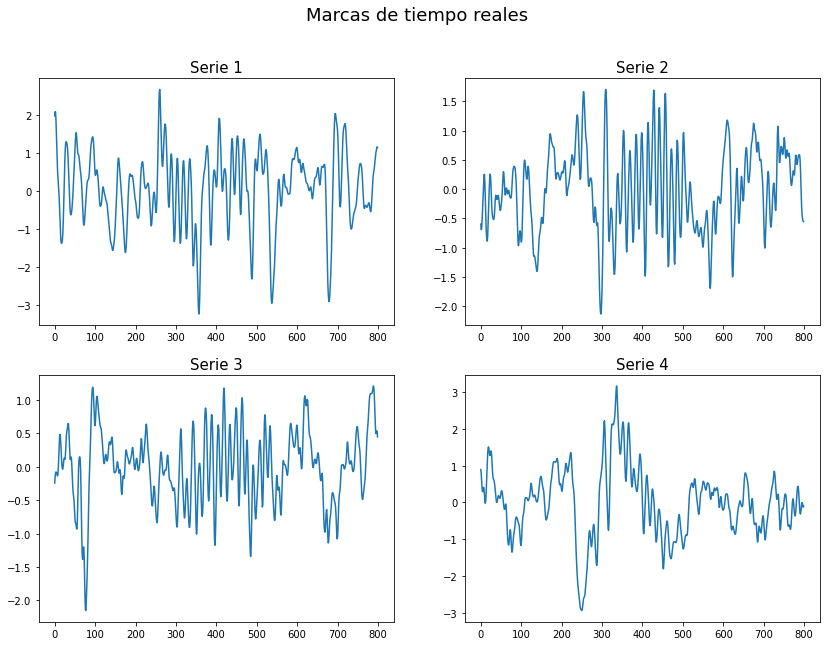

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14,10))

t = np.arange(800)
axs[0, 0].plot(t, test_signals[0])
#axs[0, 0].vlines(test_marks[0], -3, 3, colors='r')
#axs[0, 0].vlines(predicciones[0], -3, 3, colors='black')
axs[0, 0].set_title('Serie 1', size=15)

axs[0, 1].plot(t, test_signals[1])
#axs[0, 1].vlines(test_marks[1], -2, 2, colors='r')
#axs[0, 1].vlines(predicciones[1], -2, 2, colors='black')
axs[0, 1].set_title('Serie 2', size=15)

axs[1, 0].plot(t, test_signals[2])
#axs[1, 0].vlines(test_marks[2], -2, 1, colors='r')
#axs[1, 0].vlines(predicciones[2], -2, 1, colors='black')
axs[1, 0].set_title('Serie 3', size=15)

axs[1, 1].plot(t, test_signals[3])
#axs[1, 1].vlines(test_marks[3], -3, 3, colors='r')
#axs[1, 1].vlines(predicciones[3], -3, 3, colors='black')
axs[1, 1].set_title('Serie 4', size=15)

fig.suptitle('Marcas de tiempo reales', fontsize=18)
fig.show()